In [1]:
import pandas as pd
import numpy as np
import folium
import re

import matplotlib.pyplot as plt
import seaborn as sns

from utils.LLM import procesamiento_batch_paralelo
from utils.manejador_bucket import leer_archivo_desde_space
from utils.nlp import obtener_frecuencias
from utils.general import comparar_valores
from utils.geocode import haversine
from utils.geocode import obtener_coordenadas
from utils.general import procesar_en_paralelo
from utils.geocode import obtener_direccion

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/luis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = leer_archivo_desde_space("precios-depas-lima/csv/data-formateada.csv")
df.head()


KeyboardInterrupt



In [5]:
data = df.copy()

## 1. Análisis y formateo de datos

Apartir del conocimiento que tengamos sobre el negocio haremos un primer analisis y limpieza de la inconsistencias en los datos.

In [6]:
data.isnull().mean().sort_values(ascending=False)

banios/2             0.839089
estacionamiento      0.619599
precio_dolares       0.558669
area_cubierta        0.436630
antiguedad           0.305912
longitud             0.284939
latitud              0.284939
area_total           0.065992
banos                0.050624
dormitorios          0.041765
moneda               0.019346
precio_soles         0.019346
descripcion          0.014645
fecha_publicacion    0.000542
distrito             0.000000
dtype: float64

Podemos ver que existe un gran % de nulos en las variables de **banio/2, estacionamiento, precio_dolares, area_cubierta y antiguedad**.

In [7]:
data.describe().T

count          mean           std        min          25%  \
fecha_publicacion  5528.0  2.226845e+01  3.945093e+01   0.000000     5.000000   
banios/2            890.0  1.105618e+00  4.550330e-01   1.000000     1.000000   
latitud            3955.0 -1.211143e+01  3.337834e-02 -13.115875   -12.131685   
antiguedad         3839.0  3.412404e+02  7.454059e+02   0.000000     3.000000   
dormitorios        5300.0  2.178491e+00  9.078247e-01   1.000000     1.000000   
area_cubierta      3116.0  1.001072e+02  8.963541e+01   1.000000    55.000000   
precio_dolares     2441.0  3.332150e+04  1.677951e+05  65.000000   680.000000   
longitud           3955.0 -7.702723e+01  3.415073e-02 -77.148619   -77.042717   
banos              5251.0  1.847458e+00  8.539894e-01   1.000000     1.000000   
estacionamiento    2104.0  1.314639e+00  5.922744e-01   1.000000     1.000000   
area_total         5166.0  3.206843e+02  1.534320e+04   2.000000    55.000000   
precio_soles       5424.0  2.285129e+06  8.201599e+07   1.000000  1778.750000   

                           50%         75%           max  
fecha_publicacion    12.000000    30.00000  3.650000e+02  
banios/2              1.000000     1.00000  6.000000e+00  
latitud             -12.113617   -12.08905 -1.194805e+01  
antiguedad            9.000000    19.00000  2.025000e+03  
dormitorios           2.000000     3.00000  1.000000e+01  
area_cubierta        76.000000   110.00000  1.200000e+03  
precio_dolares      862.000000  1350.00000  2.500000e+06  
longitud            -77.026159   -77.01731 -7.632847e+01  
banos                 2.000000     2.00000  2.200000e+01  
estacionamiento       1.000000     2.00000  6.000000e+00  
area_total           76.000000   110.00000  1.102861e+06  
precio_soles       2450.000000  3420.00000  3.021000e+09

Podemos ver que existen varios valores inconsistentes en los **máximos** y **mínimos** de las variables que van a tener que ser tratados.
Sin embargo existe una variable que falta ser formateada, estamos hablando de 'antiguedad', esta variable representa la antiguedad asi como el año de construcción del departamento.

In [8]:
# moneda que acompaña a la variable precio_soles(precio)
data['moneda'].value_counts()

moneda
S/     3188
S/.    2020
US$     216
Name: count, dtype: int64

Esta moneda es la que acompaña a la variable precio_soles, que en teoria deberia estar ya formateada a soles, pero no lo esta.

In [9]:
# distritos de lima que se encuentran en nuestro estudio
data['distrito'].value_counts()

distrito
miraflores     888
barranco       721
cercado        500
surquillo      485
san-borja      429
surco          388
san-miguel     372
san-isidro     358
lince          353
jesus-maria    344
magdalena      241
la-molina      223
chorrillos     148
chorillos       81
Name: count, dtype: int64

Se puede ver que el distrito de Chorrillos se representa de 2 formas (error de tipeo) -> 'chorillos' y 'chorrillos'

### To Do


Podemos ver que para las variables:
- banios/2: El % de nulos es muy alto además su definición es ambigua, ya que no todos los departamentos consideran un baño de invitados como un baño diferente al resto.
- estacionamiento: El % de nulos es muy alto además si un departamento tiene cochera no queda claro si esta se encuentra dentro del precio del departamento o es un costo aparte.
- precio_dolares: El precio en soles brinda la misma información, solo vamos a usarlo para el caso de que el precio en soles sea nulo. 
- area_cubiera: El área cubierta no queda siempre claro, ya que no es una variable que se encuentre presente siempre.
- precio_soles: Este precio no se encuentra en soles, ya que la variable 'moneda' es la que define su conversion.
- distrito: El distrito de Chorrillos se encuentra como 'chorillos' y 'chorrillos'.
- antiguedad : Los valores de antiguedad representa 2 cosas, la primera es la antiguedad propiamente dicha (en años, tomando de referencia el año actual) y la otra es el año de construccion del departamento. 

Apartir de lo dicho vamos a realizar lo siguiente:

**1. Convertiremos a soles todos los precios (que en teoria estaban en soles) a soles.**

**2. Usaremos el valor de 3.7*precio_dolares para imputar los valores nulos de la variable precio_soles.**

**3. Corregiremos el distrito de Chorrillos**

**4. Corregiremos la variable antiguedad haciendo antiguedad=2025-antiguedad para toda antiguedad que represente un año, es decir, antiguedad>1000**

**5. Eliminaremos las variables banios/2, estacionamiento y area_cubierta por ambiguedad, precio_dolares por redundancia y moneda irrelevante**

**6. Renombraremos las variables precio_soles y area_total a precio y area respectivamente.**

In [10]:
# 1. 
data['precio_soles'] = np.where(data['moneda']=='US$',3.7*data['precio_soles'], data['precio_soles'])

# 2. 
data['precio_soles'] = np.where(data['precio_soles'].isna(),3.7*data['precio_dolares'], data['precio_soles'])

# 3. 
data['distrito'] = np.where(data['distrito']=='chorillos','chorrillos', data['distrito'])

# 4.
data['antiguedad'] = np.where(data['antiguedad']>1e3,2025-data['antiguedad'],data['antiguedad'])

# 5.
data.drop(columns=['precio_dolares','banios/2','estacionamiento','area_cubierta',"moneda"],inplace=True)

# 6.
data.rename(columns={"precio_soles":"precio","area_total":"area"},inplace=True)

In [11]:
data.head()

fecha_publicacion    latitud  antiguedad  dormitorios   longitud  banos  \
0                0.0 -12.139912         5.0          3.0 -77.018606    2.0   
1                0.0 -12.139912         5.0          3.0 -77.018606    2.0   
2                1.0 -12.139272         0.0          2.0 -77.021154    2.0   
3                1.0 -12.139555         8.0          1.0 -77.023879    1.0   
4                1.0 -12.138541        10.0          3.0 -77.017627    2.0   

                                         descripcion  area  precio  distrito  
0  Se Alquila Lindo Departamento en Barranco\n¡De...  77.0  2960.0  barranco  
1  Se Alquila Lindo Departamento en Barranco\n¡De...  77.0  2960.0  barranco  
2  Se Alquila Departamento Duplex en Corazón de B...  96.0  2250.0  barranco  
3  Se Alquila Lindo Departamento en Barranco\nSE ...  40.0  2000.0  barranco  
4  Departamento de 3 Habitaciones Sin Amoblar en ...  80.0  2974.0  barranco

### 2. Analisis y correcion de inconsistencias

En este apartado analizaremos la data en busca de inconsistencias en cada variable, las que sean más obvias y puedan detectarse sin ningún análisis profundo en los datos.

**2.1. Variables antiguedad, dormitorios, banos, area, precio**

In [12]:
data.drop_duplicates(subset=['latitud','longitud','area','dormitorios','banos','precio','distrito','antiguedad'],inplace=True)
data.shape

(3881, 10)

Eliminamos los duplicados en los datos, ya que el mismo departamento puede ser reposteado y por lo tanto scrapeado, varias veces.

In [14]:
data.describe().T

count           mean           std        min  \
fecha_publicacion  3878.0      21.908974  3.881986e+01   0.000000   
latitud            2685.0     -12.108532  3.580847e-02 -13.115875   
antiguedad         2559.0       9.970301  1.407705e+01   0.000000   
dormitorios        3757.0       2.212404  9.103157e-01   1.000000   
longitud           2685.0     -77.027040  3.843717e-02 -77.148619   
banos              3745.0       1.859012  8.693435e-01   1.000000   
area               3650.0     410.809589  1.825333e+04   2.000000   
precio             3846.0  835640.751742  4.871395e+07   2.000000   

                           25%          50%          75%           max  
fecha_publicacion     5.000000    12.000000    30.000000  3.650000e+02  
latitud             -12.126975   -12.104623   -12.086893 -1.194805e+01  
antiguedad            2.000000     8.000000    14.000000  5.250000e+02  
dormitorios           1.000000     2.000000     3.000000  1.000000e+01  
longitud            -77.045534   -77.027641   -77.010981 -7.632847e+01  
banos                 1.000000     2.000000     2.000000  2.200000e+01  
area                 57.000000    78.000000   110.000000  1.102861e+06  
precio             1800.000000  2470.000000  3500.000000  3.021000e+09

Podemos notar ciertas variables cuyos rangos de valores se alejan mucho de los rangos "normales" que se esperarian para esas variables.

- antiguedad : Existe un valor extremo superior de 525 años de antiguedad lo cual claramente es un error.
- dormitorios: Existe un valor extremo superior de 10 dormitorios para un departamento.
- banos: Existe un valor extremo superior de 22 baños para un departamento.
- area : Existe un valor inferior de 2 m2 y un valor superior de 1M m2 lo cual claramente son errores.
- precio : Existe un valor inferior de 2 soles y un valor superior de 3M en soles para un departamento en alquiler. 

### To Do

Las inconsitencias en las variables, se pueden deber a 2 cosas
1. Errores en los datos(tipeo), estos errores pueden ser reemplazados por null y luego intentar encontrar esa informacion en la descripción del departamento.
2. Error en el objeto de estudio, en este caso nuestro objeto de estudio es departamentos en alquiler, cualquier otro tipo de inmueble diferente, por ejemplo, terrenos (lo que explicaría el área tan grande), cocheras o depósitos (lo que explicaría el área tan pequeña), departamentos en **venta**,en lugar de alquiler,(lo que explicaría el precio tan elevado), no tendría ningún sentido trabajar con ellas por lo que deberan ser eliminadas. 

Para poder detectar si se trata de alguno de estos vamos a usar la descripción y una LLM que nos ayude a clasificar el texto en: 
1. departamento o no departamento.
2. alquiler, venta o ambos.

Para cada resultado de la clasificación:

1. Clasificación departamento o no departamento: Eliminar las propiedades que no hayan sido clasificadas como departamentos.
2. Clasificación alquiler, venta o ambos: Comparar la mediana entre los precios de los departamentos clasificados como venta con los precios de departamentos clasficados como alquiler, para poder determinar si realmente existe una diferencia significativa entre estos precios que indique una compra en lugar de un alquiler. Si la diferencia es significativa entonces procederemos a eliminar los departamentos clasificados como venta. Por ultimo convertimos a nulo las inconsistencias de los departamentos clasificados como alquiler para que puedan ser tratados mas adelante.  

Si bien es posible que existan departamentos que puedan tener ciertos tipos de valores que pueden ser considerados inconsistencias la singularidad de estos hace que sea inapreciable su eliminacion.
 

In [15]:
data_copia = data.copy()

In [16]:
system_message = '''
 Eres un asistente experto en clasificar propiedades apartir de su descripcion.
 Tu objetivo es analizar el texto y determinar la propiedad que es:
  1. propiedad : Departamento, Local comercial, oficina, terreno, casa, cochera, otro. Existen 3 posibles salidas para esta variable:
 - 'departamento': Abarcar todos los tipos de departamento (mini departamento, flat o solo un piso, duplex o de dos pisos, triplex o de tres pisos,penthouse o pent house, etc.)
 - 'no_departamento': Local comercial, oficina, terreno, casa, cochera, otro.
 - null : Si no se puede determinar.
 2. propuesta: El tipo de propuesta que se esta haciendo, Existen 4 posibles salidas para esta variable:
 - 'venta': Unicamente se ofrece venta.
 - 'alquiler': Unicamente se ofrece alquiler.
 - 'alquiler y venta' : Se ofrecen ambos.
 - null : Si no se puede determinar.
 
 El resultado debe devolverse exclusivamente en formato JSON con la siguiente estructura, sin ningun comentario, ni anotaciones, ni explicaciones, SOLO EL JSON\n

[{'id':<id>, 'variable':<variable>,'propiedad':<propiedad_o_null>,'propuesta'::<tipo_proupuesta_o_null>},...]
'''

user_message = '''
Aquí tienes una lista de propiedades en formato JSON:\n

{}\n\n

Devuélveme únicamente el JSON en el formato especificado, sin comentarios, ni anotaciones, ni explicaciones adicionales.
'''

Definimos el prompt de usuario y de sistema para la LLM.

In [17]:
queries = ["area<25", "area>700", "precio<200", "precio>2e4", "antiguedad>50", "dormitorios>7", "banos>7"]

exp = re.compile("\w+")

entradas = []

for querie in queries:
    variable = exp.findall(querie)[0]
    indices = data.query(querie).index
    entradas += [{'id':f[0],'descripcion':f[1]['descripcion'],'variable':variable} for f in data.loc[indices].iterrows()]


In [18]:
clasificacion_de_propiedades = procesamiento_batch_paralelo(
    input_data=entradas, # data total a procesar
    k=20, # numero de descripciones por batch
    system_message=system_message, # mensaje del sistema
    user_message=user_message, # mensaje del usuario
    max_workers=5 # paralelizar la ejecucion, obs: numero_de_tokens<200k
)

2025-03-01 22:55:28,581 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:29,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:29,653 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:30,493 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:31,752 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:39,320 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:39,760 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:42,707 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 22:55:44,546 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In [19]:
clasificacion_prop_df = pd.DataFrame(clasificacion_de_propiedades).set_index('id')
print("Clasificacion de propiedad")
print(clasificacion_prop_df['propiedad'].value_counts())

print("Alquiler vs Venta")
print(clasificacion_prop_df['propuesta'].value_counts())

Clasificacion de propiedad
propiedad
departamento       243
no_departamento     21
null                 2
cochera              1
Name: count, dtype: int64
Alquiler vs Venta
propuesta
alquiler            130
alquiler y venta     68
venta                21
null                 19
Name: count, dtype: int64


In [20]:
# 1. Eliminamos los que no sean departamentos
indices1 = clasificacion_prop_df.query("propiedad!='departamento'").index

# 2. Verificamos la proporcion entre la mediana de los precios de venta y los precios de alquiler 
indices_no_alquiler = clasificacion_prop_df.query("propiedad=='departamento' and propuesta!='alquiler'").index
indices_alquiler = clasificacion_prop_df.query("propiedad=='departamento' and propuesta=='alquiler'").index
proporcion = data.loc[indices_no_alquiler,'precio'].median()/data.loc[indices_alquiler,'precio'].median()
print(f"Los clasificados como 'venta' cuestan {np.round(proporcion,0)} veces más que los clasificados como 'alquiler'")
indices2 = indices_no_alquiler

indices_drop = list(set(indices1) | set(indices2))
data_copia.drop(index=indices_drop,inplace=True)

Los clasificados como 'venta' son 419.0 veces más que los clasificados como 'alquiler'


In [21]:
filas = clasificacion_prop_df.loc[indices_alquiler].iterrows()
for fila in filas:
    indice = fila[0]
    variable = fila[1]['variable']
    data_copia.at[indice,variable] = None

In [22]:
data_copia.describe().T

count         mean          std         min          25%  \
fecha_publicacion  3730.0    19.980429    32.496597    0.000000     5.000000   
latitud            2554.0   -12.108359     0.036157  -13.115875   -12.126558   
antiguedad         2417.0     9.296235     8.608191    0.000000     2.000000   
dormitorios        3620.0     2.196409     0.887006    1.000000     1.000000   
longitud           2554.0   -77.027083     0.038823  -77.148619   -77.045789   
banos              3607.0     1.835875     0.780524    1.000000     1.000000   
area               3431.0    94.223259    63.181171    5.000000    58.000000   
precio             3675.0  2894.308054  2149.521222  222.000000  1799.500000   

                           50%          75%           max  
fecha_publicacion    11.000000    30.000000    365.000000  
latitud             -12.103890   -12.086701    -11.948054  
antiguedad            8.000000    14.000000     50.000000  
dormitorios           2.000000     3.000000      7.000000  
longitud            -77.027663   -77.010521    -76.328472  
banos                 2.000000     2.000000      6.000000  
area                 76.000000   108.000000    700.000000  
precio             2400.000000  3300.000000  19855.000000

In [23]:
data = data_copia.copy()

**2.2. Coordenadas**

In [24]:
# Listas de coordenadas (latitudes y longitudes)
data_coord = data.query("latitud.notna() and longitud.notna()")
latitudes = data_coord['latitud']
longitudes = data_coord['longitud']

# Crear un mapa centrado en Lima, Perú
m = folium.Map(location=[-12.06, -77.05], zoom_start=13)

# Agregar marcadores con etiquetas
for lat, lon in zip(latitudes, longitudes):
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color="blue", icon="home")
    ).add_to(m)

# Guardar el mapa en un archivo HTML y mostrarlo
m.save("mapa_departamentos.html")
m

Se puede ver que existen ciertos departamentos que se ubican en calles, avenidas, etc, lo cual implica que las coordenadas de estos departamentos no representan la ubicación exacta del departamento, por lo que puede introducir un sesgo a nuestro modelado y análisis.

**TO DO**

 Para poder lidiar con esto vamos a agregar nuevas variables a partir de la api de geocode, que nos brinden información acerca de la exactitud de la ubicación del departamento a partir de las coordenadas geográfica.  

Vamos a procesar las coordenadas y obtener:

- direccion : Direccion del departamento.
- precision : La precision de la direccion.
- type : El tipo de direccion.  

La idea esta que el modelo pueda aprender a combinar estas variables para poder saber cuando las coordenadas deben tener una mayor impotancia y cuando no, apartir de la precision de estas.

In [120]:
data_coord = data.query("latitud.notna() and longitud.notna()")
data_coord_json = [{"id":id,"latitud":fila["latitud"],"longitud":fila["longitud"]}
                    for id,fila in data_coord[['latitud','longitud']].iterrows()]


In [121]:
direcciones_precision = procesar_en_paralelo(obtener_direccion,data_coord_json,7)

{'id': 4, 'direccion': 'Edificio El Sol 450, Av. el Sol Oeste 448, Barranco 15063, Peru', 'precision': 'ROOFTOP', 'type': 'street_address'}
{'id': 5, 'direccion': 'Av. Almte. Miguel Grau 1108, Lima 15063, Peru', 'precision': 'ROOFTOP', 'type': 'street_address'}
{'id': 3, 'direccion': 'Av. República de Panamá 330, Barranco 15049, Peru', 'precision': 'ROOFTOP', 'type': 'establishment'}
{'id': 1, 'direccion': 'Jr. Tumbes 306, Lima 15063, Peru', 'precision': 'ROOFTOP', 'type': 'street_address'}
{'id': 6, 'direccion': 'Av. República de Panamá 3, Barranco 15049, Peru', 'precision': 'ROOFTOP', 'type': 'street_address'}
{'id': 2, 'direccion': 'Av. el Sol Oeste 203 - 504, Barranco 15063, Peru', 'precision': 'ROOFTOP', 'type': 'establishment'}
{'id': 0, 'direccion': 'Ca. Enrique Barrón 280, Barranco 15063, Peru', 'precision': 'ROOFTOP', 'type': 'street_address'}
{'id': 7, 'direccion': 'Auxiliar Av. Pedro de Osma 315, Barranco 15063, Peru', 'precision': 'ROOFTOP', 'type': 'street_address'}
{'id':

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7d371bf51b70>>
Traceback (most recent call last):
  File "/home/luis/Proyectos/PrecioDeDepartamentos/Precios-depas-git/ProyectoDepas/2.0.StaggingLayer/StagingLayerProject/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [27]:
direc_precision_df = pd.DataFrame(direcciones_precision).set_index('id')  
data_merge = pd.merge(data,direc_precision_df,left_index=True,right_index=True,how='left')
data_merge

fecha_publicacion    latitud  antiguedad  dormitorios   longitud  banos  \
0                   0.0 -12.139912         5.0          3.0 -77.018606    2.0   
2                   1.0 -12.139272         0.0          2.0 -77.021154    2.0   
3                   1.0 -12.139555         8.0          1.0 -77.023879    1.0   
4                   1.0 -12.138541        10.0          3.0 -77.017627    2.0   
6                   1.0 -12.138338         5.0          2.0 -77.025239    1.0   
...                 ...        ...         ...          ...        ...    ...   
5470                3.0 -12.139272         0.0          2.0 -77.021154    2.0   
5522                0.0 -12.115735        10.0          1.0 -77.019023    1.0   
5530                5.0 -12.089232         4.0          1.0 -77.028411    1.0   
1740                NaN        NaN         NaN          NaN        NaN    NaN   
5135                NaN        NaN         NaN          NaN        NaN    NaN   

                                            descripcion  area  precio  \
0     Se Alquila Lindo Departamento en Barranco\n¡De...  77.0  2960.0   
2     Se Alquila Departamento Duplex en Corazón de B...  96.0  2250.0   
3     Se Alquila Lindo Departamento en Barranco\nSE ...  40.0  2000.0   
4     Departamento de 3 Habitaciones Sin Amoblar en ...  80.0  2974.0   
6     Se Alquila Lindo Departamento en La Av El Sol ...  70.0  2800.0   
...                                                 ...   ...     ...   
5470  Se Alquila Departamento Duplex en Corazón de B...  96.0  2250.0   
5522  Surquillo Minidepa Funcional 700 Soles Incluye...  35.0   700.0   
5530  Departamento Exclusivo en Alquiler en Lince 1 ...  49.0  2300.0   
1740                                                NaN   NaN     NaN   
5135                                                NaN   NaN     NaN   

       distrito                                          direccion  \
0      barranco       Ca. Enrique Barrón 280, Barranco 15063, Peru   
2      barranco                   Jr. Tumbes 306, Lima 15063, Peru   
3      barranco   Av. el Sol Oeste 203 - 504, Barranco 15063, Peru   
4      barranco  Av. República de Panamá 330, Barranco 15049, Peru   
6      barranco  Edificio El Sol 450, Av. el Sol Oeste 448, Bar...   
...         ...                                                ...   
5470  surquillo                   Jr. Tumbes 306, Lima 15063, Peru   
5522  surquillo                    VXMJ+PC2, Surquillo 15047, Peru   
5530  surquillo                  Orquideas 2631, Lince 15046, Peru   
1740        NaN                                                NaN   
5135        NaN                                                NaN   

             precision            type  
0              ROOFTOP  street_address  
2              ROOFTOP  street_address  
3              ROOFTOP   establishment  
4              ROOFTOP   establishment  
6              ROOFTOP      subpremise  
...                ...             ...  
5470           ROOFTOP  street_address  
5522  GEOMETRIC_CENTER   establishment  
5530           ROOFTOP  street_address  
1740               NaN             NaN  
5135               NaN             NaN  

[3735 rows x 13 columns]

Convertimos a dataframe para un mejor manejo.

In [28]:
data_merge['precision'].value_counts()

precision
ROOFTOP             2351
GEOMETRIC_CENTER     203
Name: count, dtype: int64

La precision indica la precisión del resultado geocodificado. En este caso, hay dos tipos principales:

- ROOFTOP: Indica la ubicación exacta de un edificio o dirección específica.
- GEOMETRIC_CENTER: Se refiere al centro geométrico de una zona o lugar, en lugar de un punto exacto.

In [29]:
data_merge['type'].value_counts()

type
street_address       1241
establishment         598
premise               470
subpremise            168
clothing_store         15
cafe                    8
doctor                  8
car_repair              7
church                  5
bus_station             4
accounting              4
electrician             3
bar                     3
atm                     3
convenience_store       3
bakery                  2
book_store              2
car_wash                2
embassy                 1
electronics_store       1
car_dealer              1
bicycle_store           1
dentist                 1
route                   1
plus_code               1
beauty_salon            1
Name: count, dtype: int64

El type indica el tipo de lugar asociado con la dirección o coordenada, existen varios tipos:

- street_address: Dirección de una calle.
- establishment: Un negocio o establecimiento en general.
- premise / subpremise: Un edificio o una subdivisión dentro de un edificio (por ejemplo, departamentos o suites).
- clothing_store, cafe, doctor, car_repair, church, etc.: Tipos específicos de negocios o lugares.

In [31]:
data = data_merge.copy() 

Esta informacion ayudara a determinar que tan exacta es una coordenada para poder filtrarlos en caso de un analisis o el modelo pueda aprender a usarlas.

### 3. Tratamiento de nulos con la descripcion

In [32]:
data.isnull().mean().sort_values(ascending=False)

antiguedad           0.352878
longitud             0.316198
latitud              0.316198
type                 0.316198
precision            0.316198
direccion            0.316198
area                 0.081392
banos                0.034270
dormitorios          0.030790
precio               0.016064
descripcion          0.004284
fecha_publicacion    0.001339
distrito             0.000535
dtype: float64

In [33]:
descripciones = data['descripcion'].dropna().apply(lambda x: x.lower())
frecuencias = dict(obtener_frecuencias(descripciones,1000))

In [34]:
dormitorios = frecuencias['dormitorios'] + frecuencias['dormitorio'] + frecuencias['dorm']
banos = frecuencias['baño'] + frecuencias['baños']
area = frecuencias['area'] + frecuencias['área']
antiguedad = frecuencias['antigüedad'] + frecuencias['antiguedad'] + frecuencias['años']
direccion = frecuencias['dirección'] + frecuencias['avenida'] + frecuencias['av'] +  frecuencias['ubicación']

print(f"Numero de palabras relacionadas a los dormitorios {dormitorios}")
print(f"Numero de palabras relacionadas a los banos {banos}")
print(f"Numero de palabras relacionadas a los area {area}")
print(f"Numero de palabras relacionadas a los antiguedad {antiguedad}")
print(f"Numero de palabras relacionadas a la dirección {direccion}")

Numero de palabras relacionadas a los dormitorios 5334
Numero de palabras relacionadas a los banos 6955
Numero de palabras relacionadas a los area 2977
Numero de palabras relacionadas a los antiguedad 969
Numero de palabras relacionadas a la dirección 4519


Como podemos ver, la descripción nos aporta información acerca de la propiedad, como el tipo de propiedad en el inciso anterior, además podemos encontrar ciertas palabras clave como "baños", "dormitorios", etc. que son caracteristicas que ya encontramos en la data estructurada.

### TO DO

Usaremos la descripción y un modelo LLM como ChatGPT para extraer esta información. Sin embargo, lo haremos en dos partes para estructurar mejor la solicitud y mejorar la calidad de las respuestas.

1. En la primera parte, identificaremos las entidades clave en la descripción, como el número de dormitorios, baños, área y antigüedad del departamento.
2. En la segunda parte, indentificaremos las direcciones y la exactitud de estas para poder determinar posteriomente las coordenadas.

A partir de los incisos anteriores, observamos que la descripción contiene términos relacionados con el número de dormitorios, baños, el área, la antigüedad y la dirección del departamento. Esto sugiere que en la descripción hay información relevante sobre estas variables, la cual podría extraerse y utilizarse para imputar los valores nulos. 

**primera parte**

In [35]:
mensaje_sistema = (
    "Eres un asistente experto en procesar descripciones de propiedades en español. "
    "Tu tarea es extraer y determinar: número de dormitorios, baños, el área y la antiguedad de cada propiedad. "
    "En el texto, busca los valores de área (sinónimos: area, superficie, m2, metros, etc.) -> Ejemplos: '80m²', 'superficie 120 m²', 'area 120', etc.; "
    "dormitorios (sinónimos: dormitorios, cuartos, hab, habitaciones, etc.) -> Ejemplos: '2 dormitorios', '3 habitaciones', '2 dorm'; "
    "baños (sinónimos: baño, baños, wc, aseos, etc.) -> Ejemplos: '1 baño', '2 baños', etc.; "
    "antiguedad (sinónimos: antiguedad, edad, año, año de construcción, etc.) -> Ejemplos: '10 años', 'año de construccion 2015', etc.; "
    "Si no encuentras el dato en la descripción, devuelve None. "
    "Devuelve únicamente un JSON con la siguiente estructura: "
    "[{'id': <id>, 'area': <valor_o_None>, 'dormitorios': <valor_o_None>, 'banos': <valor_o_None>, 'antiguedad': <valor_o_None>, ...]."
)

mensaje_user = (
    "Aquí tienes la siguiente lista de propiedades en formato JSON:\n"
    "{}\n\n"  # Placeholder para .format(json_input_data)
    "Por favor, extrae el área, los dormitorios, los baños y antiguedad (o año de construccion) de cada descripción. "
    "- Devuelve únicamente el JSON en el formato solicitado, cada valor numerico sin ninguna unidad"
)

Creamos los mensajes del sistema y el de usuario para poder extraer de la forma mas precisa posible la informacion de las variables en el formato adecuado. 

In [36]:
data_null = data.query('banos.isna() or dormitorios.isna() or antiguedad.isna() or area.isna()')
data_prueba = data.query('antiguedad.notna()').sample(500)
data_null = pd.concat([data_null, data_prueba],axis=0)
descripciones_para_procesar = [{"id":id,"descripcion":descripcion} for id,descripcion in data_null['descripcion'].items() if descripcion]
len(descripciones_para_procesar)

2008

Tomamos todas las instancias que contengan valores nulos en alguna de las variables y ademas tomamos una muestra de 500 variables no nulas para antiguedad ya que esta posee un gran % de nulos por lo que sera complicado poder testear la extracción para esta variable.

In [37]:
imputaciones = procesamiento_batch_paralelo(
    input_data=descripciones_para_procesar, # data total a procesar
    k=20, # numero de descripciones por batch
    system_message=mensaje_sistema, # mensaje del sistema
    user_message=mensaje_user, # mensaje del usuario
    max_workers=4 # paralelizar la ejecucion, obs: numero_de_tokens<200k
)

2025-03-01 23:07:24,767 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:25,309 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:25,857 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:39,822 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:39,846 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:43,281 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:47,604 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:52,693 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:07:53,387 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In [40]:
imputaciones_df = pd.DataFrame(imputaciones).set_index('id')
for col in imputaciones_df:
    imputaciones_df[col] = pd.to_numeric(imputaciones_df[col], errors='coerce')
imputaciones_df.describe()

area  dormitorios        banos   antiguedad
count  1216.000000  1845.000000  1808.000000   255.000000
mean     92.887854     2.176152     1.723451    88.680392
std      68.218886     0.859347     0.728587   389.816180
min       0.000000     0.000000     1.000000     0.000000
25%      56.750000     1.000000     1.000000     3.000000
50%      76.000000     2.000000     2.000000     8.000000
75%     105.000000     3.000000     2.000000    15.000000
max    1200.000000     5.000000     5.500000  2023.000000

In [42]:
def comparar_valores_(data_real,data_convertida,columnas):

    data_real_filtrada = data_real.loc[data_convertida.index,columnas.keys()]
    data_convertida_col = data_convertida.rename(columns=dict([(col,col+"_imp")for col in columnas.keys()]))
    data_comparacion = pd.concat([data_real_filtrada, data_convertida_col], axis=1)
    coincidencias = []

    for col,val in columnas.items():

        data_comparacion_col = data_comparacion.query(f"{col}.notna() and {col}_imp.notna()")

        # diferencia entre la columna real y la convertida
        data_comparacion_col[f'{col}_diff'] = np.abs(data_comparacion_col[col] - data_comparacion_col[f'{col}_imp'])

        # el total de elementos comparados
        total = data_comparacion_col.shape[0]

        # el total de elementos que cumplen con el error de tolerancia
        cumplen = 0
        if val<1 and val>0: # es una proporcion (el error es menor que el x% del valor)
            cumplen = data_comparacion_col.query(f'{col}_diff/{col} <= {val}').shape[0]
        elif val>=1 or val==0: # es un valor (el error es igual o menor que el valor)
            cumplen = data_comparacion_col.query(f'{col}_diff <= {val}').shape[0]
        else:
            print('El valor de comparación debe ser un número mayor que 0.')

        # proporcion de los que cumplen con la tolerancia del error
        coincidencias_col = cumplen/total
        coincidencias.append(coincidencias_col)
        print(f"El % de coincidencias para la columna '{col}': {coincidencias_col*100:.2f}% de {total}")

    return data_comparacion,coincidencias


Funcion para poder comparar los valores y saber cual es el % que cumple con el error de tolerancia maximo.

In [43]:
imputaciones_df['antiguedad'] = np.where(imputaciones_df['antiguedad']>1e3,2025-imputaciones_df['antiguedad'],imputaciones_df['antiguedad'])

tolerancia = {
    "area":0.1, # tolerancia del 10% del valor real del area
    "dormitorios":0, # concordancia exacta
    "banos":0, # concordancia exacta
    "antiguedad":2 # tolerancia de 2 años de antiguedad
}

data_comparacion,coincidencias = comparar_valores_(data,imputaciones_df,tolerancia)

El % de coincidencias para la columna 'area': 93.34% de 1066
El % de coincidencias para la columna 'dormitorios': 94.73% de 1766
El % de coincidencias para la columna 'banos': 81.13% de 1701
El % de coincidencias para la columna 'antiguedad': 84.27% de 89


Como podemos ver existe un gran % de valores que cumplen con la tolerancia minima (mayor que el 80%).

In [44]:
for col in tolerancia.keys():
    data_comparacion[f'{col}_fin'] = np.where(data_comparacion[col].isna(),
                                              data_comparacion[f'{col}_imp'],
                                              data_comparacion[col])
    numero_reducido = data_comparacion[col].isnull().sum() - data_comparacion[f'{col}_fin'].isnull().sum()
    print(f"La variable {col} redujo {numero_reducido} nulos")
    

La variable area redujo 150 nulos
La variable dormitorios redujo 79 nulos
La variable banos redujo 107 nulos
La variable antiguedad redujo 166 nulos


Veamos la cantidad de nulos que estamos reduciendo.

In [45]:
columnas = tolerancia.keys()
data.loc[data_comparacion.index,columnas] = data_comparacion[[f'{col}_fin' for col in columnas]].values
data.describe()

fecha_publicacion      latitud   antiguedad  dormitorios     longitud  \
count        3730.000000  2554.000000  2583.000000  3690.000000  2554.000000   
mean           19.980429   -12.108359     9.300619     2.194580   -77.027083   
std            32.496597     0.036157     8.637928     0.891861     0.038823   
min             0.000000   -13.115875     0.000000     0.000000   -77.148619   
25%             5.000000   -12.126558     2.000000     1.000000   -77.045789   
50%            11.000000   -12.103890     8.000000     2.000000   -77.027663   
75%            30.000000   -12.086701    14.000000     3.000000   -77.010521   
max           365.000000   -11.948054    70.000000     7.000000   -76.328472   

             banos         area        precio  
count  3707.000000  3575.000000   3675.000000  
mean      1.831535    94.351027   2894.308054  
std       0.785226    66.410396   2149.521222  
min       1.000000     1.000000    222.000000  
25%       1.000000    57.000000   1799.500000  
50%       2.000000    76.000000   2400.000000  
75%       2.000000   108.000000   3300.000000  
max       6.000000  1200.000000  19855.000000

**segunda parte**

In [46]:
system_msg = (
    "Eres un asistente experto en la indentificacion y extraccion de direcciones de propiedades en español, específicamente para los distritos de Lima, Perú. "
    "Tu tarea es extraer las direcciones lo más exactas posibles:\n\n"
    " El formato de cada direccion para cada propiedad debe ser '<direccion>, distrito, Lima, Perú.' o null."
    " EJEMPLOS: "
    " - Av. Venezuela 3252, Urb. Los Cipreses, Cercado de Lima, Lima, Perú"
    " - Av. Universitaria 1801, San Miguel, Lima, Perú"
    " - Av. Grau 651, Barranco, Lima, Perú"
    "El resultado debe ser devuelto únicamente en formato JSON, con la siguiente estructura:\n"
    "[{'id': <id>, 'direccion':<direccion_o_null>, ...].\n"
)

user_msg = (
    "Aquí tienes la siguiente lista de propiedades en formato JSON:\n"
    "{}\n\n"  # Placeholder para .format(json_input_data)
    "Por favor, corrige la dirección de cada propiedad según las instrucciones proporcionadas.\n"
    "- Si una dirección no puede corregirse alterando lo mínimo posible, asígnale el valor null.\n"
    "- Devuélveme únicamente el JSON en el formato especificado, sin ningún comentario o explicación adicional."
)


Creamos los mensajes del sistema y el de usuario para poder extraer la direccion lo mas exacta posible y en el formato adecuado.

In [47]:
data_null = data.query("latitud.isna() and longitud.isna()")
data_prueba = data.query("latitud.notna() and longitud.notna()").sample(1000)
data_prueba = pd.concat([data_null, data_prueba],axis=0)
data_prueba

fecha_publicacion    latitud  antiguedad  dormitorios   longitud  banos  \
52                 11.0        NaN         2.0          3.0        NaN    2.0   
84                  1.0        NaN         3.0          3.0        NaN    2.0   
126                35.0        NaN        21.0          4.0        NaN    3.0   
249                 3.0        NaN        16.0          2.0        NaN    3.0   
721                 0.0        NaN         NaN          2.0        NaN    2.0   
...                 ...        ...         ...          ...        ...    ...   
1516                1.0 -12.064862         3.0          2.0 -77.041950    2.0   
2210                6.0 -12.089586         NaN          3.0 -77.033948    NaN   
744                 6.0 -12.049273         NaN          1.0 -77.035049    1.0   
4602               30.0 -12.086157         7.0          3.0 -77.092322    2.0   
2047               10.0 -12.081490         1.0          1.0 -77.039772    1.0   

                                            descripcion   area   precio  \
52    Alquilo Lindo Departament en Jr. Progreso Casi...   70.0   2400.0   
84    Alquilo Duplex Penthouse de 150 m² Cerca Al Ma...  150.0   5200.0   
126   Excelente Penthouse de 4 Dorm. en Malecon Paul...  450.0  12032.0   
249   Alquilo Lindo Departamento Amplio Iluminado en...   87.0   2800.0   
721   Descripción\nALQUILER HERMOSO DEPARTAMENTO DE ...   86.0    539.0   
...                                                 ...    ...      ...   
1516  Alquiler de Departamento Semi Amoblado en Jesu...   60.0   2200.0   
2210  Descripción\nSe alquila bonito y acogedor depa...    NaN      NaN   
744   Descripción\nSe ofrece en alquiler Vivienda-Of...   35.0   1000.0   
4602  Descripción\nALQUILER DE DEPARTAMENTO AMOBLADO...   65.0   2100.0   
2047  Alquilo Departamento de 1 Dormitorio en Lince\...   40.0   2200.0   

         distrito                                         direccion precision  \
52       barranco                                               NaN       NaN   
84       barranco                                               NaN       NaN   
126      barranco                                               NaN       NaN   
249      barranco                                               NaN       NaN   
721       cercado                                               NaN       NaN   
...           ...                                               ...       ...   
1516  jesus-maria   Av Horacio Urteaga 402, Jesús María 15072, Peru   ROOFTOP   
2210        lince              Av. Arequipa 2562, Lince 15046, Peru   ROOFTOP   
744       cercado                  Jr. Camaná 699, Lima 15001, Peru   ROOFTOP   
4602   san-miguel            Av. La Paz 981, San Miguel 15087, Peru   ROOFTOP   
2047        lince  Jirón Coronel Manuel Gómez 451, Lima 15073, Peru   ROOFTOP   

                type  
52               NaN  
84               NaN  
126              NaN  
249              NaN  
721              NaN  
...              ...  
1516         premise  
2210         premise  
744   street_address  
4602   establishment  
2047      subpremise  

[2181 rows x 13 columns]

Tomamos 1000 muestras para poder testear la extraccion posteriormente.

In [48]:
direcciones_para_procesar = [{"id":id,"direccion":direccion} for id,direccion in data_prueba['descripcion'].items() if direccion]
len(direcciones_para_procesar)

2181

Formato de entrada.

In [49]:
direcciones = procesamiento_batch_paralelo(
    direcciones_para_procesar,
    k=20,
    system_message = system_msg,
    user_message = user_msg,
    max_workers=5
)

2025-03-01 23:53:51,578 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:53:51,645 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:53:53,116 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:53:53,132 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:53:53,136 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:54:01,407 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:54:02,664 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:54:04,079 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-01 23:54:04,482 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In [50]:
direcciones_df = pd.DataFrame(direcciones).set_index('id')
direcciones_df_join = pd.concat([direcciones_df,data.loc[direcciones_df.index,'distrito']],axis=1)
direcciones_coord = []
for id, row in direcciones_df_join.iterrows():
    direccion = row['direccion']
    distrito = row['distrito']

    # Manejar casos null/nulos
    if pd.isnull(direccion) or direccion in ['null', '']: # si no se obtuvo una direccion
        nueva_direccion = f"{distrito}, Lima, Perú." # le damos la direccion del distrito
    else:
        nueva_direccion = direccion 

    direcciones_coord.append({
        "id": id,
        "direccion": nueva_direccion
    })
len(direcciones_coord)

Si no se pudo encontrar la direccion, se asigna la del distrito.

In [52]:
coordenadas = procesar_en_paralelo(obtener_coordenadas,direcciones_coord,6)

{'id': 52, 'latitud': -12.1411508, 'longitud': -77.0221186, 'precision': 'APPROXIMATE', 'type': 'locality'}
{'id': 723, 'latitud': -12.046374, 'longitud': -77.0427934, 'precision': 'APPROXIMATE', 'type': 'locality'}
{'id': 249, 'latitud': -12.1204501, 'longitud': -77.0146784, 'precision': 'GEOMETRIC_CENTER', 'type': 'route'}
{'id': 84, 'latitud': -12.1411508, 'longitud': -77.0221186, 'precision': 'APPROXIMATE', 'type': 'locality'}
{'id': 126, 'latitud': -12.1411508, 'longitud': -77.0221186, 'precision': 'APPROXIMATE', 'type': 'locality'}
{'id': 721, 'latitud': -12.046374, 'longitud': -77.0427934, 'precision': 'APPROXIMATE', 'type': 'locality'}
{'id': 724, 'latitud': -12.046374, 'longitud': -77.0427934, 'precision': 'APPROXIMATE', 'type': 'locality'}
{'id': 726, 'latitud': -12.0506285, 'longitud': -77.0648436, 'precision': 'GEOMETRIC_CENTER', 'type': 'route'}
{'id': 727, 'latitud': -12.046374, 'longitud': -77.0427934, 'precision': 'APPROXIMATE', 'type': 'locality'}
{'id': 725, 'latitud'

Ahora procesamos las direcciones para obtener sus coordenadas, su precision y el type.

In [53]:
coordenadas_df = pd.DataFrame(coordenadas).set_index('id')
coordenadas_df

latitud   longitud         precision                         type
id                                                                       
52   -12.141151 -77.022119       APPROXIMATE                     locality
84   -12.141151 -77.022119       APPROXIMATE                     locality
126  -12.141151 -77.022119       APPROXIMATE                     locality
249  -12.120450 -77.014678  GEOMETRIC_CENTER                        route
721  -12.046374 -77.042793       APPROXIMATE                     locality
...         ...        ...               ...                          ...
4125 -12.097043 -77.033937       APPROXIMATE  administrative_area_level_3
1516 -12.064862 -77.041950  GEOMETRIC_CENTER                 intersection
2210 -12.084630 -77.034359  GEOMETRIC_CENTER                        route
744  -12.049273 -77.035049  GEOMETRIC_CENTER                        route
4602 -12.077434 -77.093414       APPROXIMATE                     locality

[2175 rows x 4 columns]

In [54]:
coordenadas_df['precision'].value_counts()

precision
APPROXIMATE           1268
GEOMETRIC_CENTER       611
ROOFTOP                224
RANGE_INTERPOLATED      72
Name: count, dtype: int64

- APPROXIMATE: Ubicación estimada sin alta precisión. Generalmente basada en datos generales de la zona.
- GEOMETRIC_CENTER: Indica el centro geométrico de un área, como una calle o un establecimiento.
- ROOFTOP: Indica una ubicación precisa sobre el techo de un edificio, ideal para direcciones exactas.
- RANGE_INTERPOLATED: Coordenadas estimadas basadas en rangos de numeración en calles donde no hay datos exactos.

In [55]:
coordenadas_df['type'].value_counts()

type
locality                       1102
route                           561
street_address                  185
administrative_area_level_3     129
premise                          69
establishment                    55
intersection                     28
political                        27
neighborhood                      7
subpremise                        7
colloquial_area                   2
church                            1
cafe                              1
bakery                            1
Name: count, dtype: int64

- locality: Representa una ciudad, pueblo o aldea.
- route: Una calle o avenida específica.
- street_address: Una dirección postal exacta, generalmente con número y nombre de la calle.
- administrative_area_level_3: División administrativa, como un distrito o municipio.
- premise: Un edificio o instalación en una dirección específica.
- establishment: Un negocio o establecimiento en general.

In [56]:
data_coord = data.loc[coordenadas_df.index,['latitud','longitud']]
coord_df_concat = coordenadas_df.rename(columns={"latitud":"latitud_api","longitud":"longitud_api"})
coord_df_comparacion = pd.concat((data_coord,coord_df_concat),axis=1)
coord_df_comparacion

latitud   longitud  latitud_api  longitud_api         precision  \
id                                                                        
52          NaN        NaN   -12.141151    -77.022119       APPROXIMATE   
84          NaN        NaN   -12.141151    -77.022119       APPROXIMATE   
126         NaN        NaN   -12.141151    -77.022119       APPROXIMATE   
249         NaN        NaN   -12.120450    -77.014678  GEOMETRIC_CENTER   
721         NaN        NaN   -12.046374    -77.042793       APPROXIMATE   
...         ...        ...          ...           ...               ...   
4125 -12.102673 -77.058936   -12.097043    -77.033937       APPROXIMATE   
1516 -12.064862 -77.041950   -12.064862    -77.041950  GEOMETRIC_CENTER   
2210 -12.089586 -77.033948   -12.084630    -77.034359  GEOMETRIC_CENTER   
744  -12.049273 -77.035049   -12.049273    -77.035049  GEOMETRIC_CENTER   
4602 -12.086157 -77.092322   -12.077434    -77.093414       APPROXIMATE   

                             type  
id                                 
52                       locality  
84                       locality  
126                      locality  
249                         route  
721                      locality  
...                           ...  
4125  administrative_area_level_3  
1516                 intersection  
2210                        route  
744                         route  
4602                     locality  

[2175 rows x 6 columns]

Ponemos todos los datos en un mismo dataframe para hacer mas facil la comparacion.

In [57]:
coord_df_comparacion['distancia'] = 1e3*coord_df_comparacion.apply(lambda row:
                                                               haversine(row['latitud'], row['longitud'],
                                                                row['latitud_api'], row['longitud_api'])
                                                               ,axis=1)

Calculemos las distancias entre los coordenadas extraidas y procesadas y las coordenadas reales.

In [58]:
coord_df_comparacion.groupby("precision")['distancia'].describe()

count         mean           std  min           25%  \
precision                                                                 
APPROXIMATE         533.0  1862.768377   6408.013962  0.0  6.328786e+02   
GEOMETRIC_CENTER    316.0  1016.850793   1905.565825  0.0  9.618095e+01   
RANGE_INTERPOLATED   30.0  9873.535445  40121.875343  0.0  7.751021e+01   
ROOFTOP             115.0   870.937309   2339.909013  0.0  1.383234e-09   

                            50%          75%            max  
precision                                                    
APPROXIMATE         1183.194834  2070.725082  142209.805309  
GEOMETRIC_CENTER     311.292726   947.107722   14482.597346  
RANGE_INTERPOLATED   883.355029  3109.498140  221247.104898  
ROOFTOP               18.587343   373.242385   12165.887401

Podemos ver que para ROOFTOP la distancia "error" es la mas pequeña, mientras que para APPROXIMATE es la mas grande.

In [60]:
coord_df_comparacion.groupby("type")['distancia'].describe().sort_values(by="count",ascending=False)

count          mean            std           min  \
type                                                                            
locality                     478.0   1847.147436    6570.154060  0.000000e+00   
route                        297.0   1025.362780    1876.148212  0.000000e+00   
street_address                91.0   1284.318796    3008.243410  0.000000e+00   
administrative_area_level_3   42.0   1469.833714     974.941282  1.478276e+02   
premise                       28.0    174.978099     344.995921  0.000000e+00   
establishment                 27.0   2167.893112    3536.100960  0.000000e+00   
intersection                  13.0    283.871568     729.640829  0.000000e+00   
political                      8.0   4960.089394   12579.237815  9.424443e+01   
neighborhood                   4.0   2023.092875    2739.729892  4.897639e+02   
subpremise                     4.0  57202.342040  109421.120662  1.383273e-09   
cafe                           1.0    496.672006            NaN  4.966720e+02   
bakery                         1.0    267.045308            NaN  2.670453e+02   
colloquial_area                0.0           NaN            NaN           NaN   
church                         0.0           NaN            NaN           NaN   

                                      25%          50%           75%  \
type                                                                   
locality                     6.627035e+02  1201.721233   2069.646160   
route                        1.062830e+02   331.290016   1016.792755   
street_address               1.383328e-09    27.171667    791.090614   
administrative_area_level_3  7.995291e+02  1223.510082   2226.576682   
premise                      1.553136e+00     8.203527     66.705277   
establishment                1.972553e+02   376.866790   2049.740870   
intersection                 1.617611e+01    32.113052    140.848156   
political                    3.011300e+02   431.473315    816.107891   
neighborhood                 5.162188e+02   741.153461   2248.027575   
subpremise                   4.594189e+00  3781.131630  60978.879481   
cafe                         4.966720e+02   496.672006    496.672006   
bakery                       2.670453e+02   267.045308    267.045308   
colloquial_area                       NaN          NaN           NaN   
church                                NaN          NaN           NaN   

                                       max  
type                                        
locality                     142209.805309  
route                         14482.597346  
street_address                16607.148829  
administrative_area_level_3    4140.958252  
premise                        1169.528954  
establishment                 11977.403745  
intersection                   2672.484953  
political                     36070.176867  
neighborhood                   6120.300694  
subpremise                   221247.104898  
cafe                            496.672006  
bakery                          267.045308  
colloquial_area                        NaN  
church                                 NaN

Podemos ver que para la distancia "error" de street_addres y premise son significativamente mas pequeñas que las demas y locality y administrative_area_level_3 son las mas grandes.

In [61]:
data_copia = data.copy()

columnas1 = ['latitud','longitud','direccion','precision','type']
columnas2 = ['latitud_api','longitud_api','direccion','precision','type']

direcciones_coord_df = pd.DataFrame(direcciones_coord).set_index('id')
direcciones_procesadas_df = pd.merge(direcciones_coord_df,coord_df_comparacion,left_index=True,right_index=True,how="left")
indices = direcciones_procesadas_df.query("latitud.isna() and latitud_api.notna()").index
data_copia.loc[indices,columnas1] = direcciones_procesadas_df.loc[indices,columnas2].values

Creamos una copia para poder reemplazar los valores y asegurarnos de que todo haya salido bien.

In [62]:
data_copia.isnull().mean().sort_values(ascending=False)

antiguedad           0.308434
area                 0.042838
precio               0.016064
dormitorios          0.012048
banos                0.007497
descripcion          0.004284
fecha_publicacion    0.001339
distrito             0.000535
latitud              0.000000
longitud             0.000000
direccion            0.000000
precision            0.000000
type                 0.000000
dtype: float64

In [63]:
data = data_copia.copy()

### 4. Limpieza y Analisis Inicial

Habiendo corregido las inconsistencias y el tratamiento de valores nulos mediante la descripción en los apartados anteriores ahora realizaremos un análisis mas profundo de las distribuciones de los datos y las inconsistencias mas a detalle. 

In [119]:
data[data.duplicated(subset=['descripcion'],keep=False)].sort_values(by='descripcion',ascending=False)

Unnamed: 0  fecha_publicacion    latitud  antiguedad  dormitorios  \
3296        4807                3.0 -12.118696        10.0          2.0   
3694        5433                5.0 -12.118696        10.0          2.0   
263          495                9.0 -12.091098         9.0          2.0   
1261        2045               10.0 -12.091098         9.0          2.0   
254          395                4.0 -12.098069        11.0          1.0   
...          ...                ...        ...         ...          ...   
828         1490               30.0 -12.071729         1.0          2.0   
7             10                1.0 -12.153240         5.0          1.0   
649         1301                3.0 -12.153240         5.0          1.0   
266          555                4.0 -12.123267         8.0          1.0   
1840        2801                3.0 -12.123267         8.0          1.0   

       longitud  banos                                        descripcion  \
3296 -77.017034    2.0  ¡Ideal Duplex Amoblado Con/sin Cochera, Barrio...   
3694 -77.017034    2.0  ¡Ideal Duplex Amoblado Con/sin Cochera, Barrio...   
263  -77.040728    2.0  Se Alquila Lindo Departamento Semi Equipado en...   
1261 -77.040728    2.0  Se Alquila Lindo Departamento Semi Equipado en...   
254  -77.068773    1.0  Se Alquila Hermoso Departamento en Av El Ejerc...   
...         ...    ...                                                ...   
828  -77.037908    2.0  Alquiler Departamento 02 Dorm. 01 Cochera Cerc...   
7    -77.022888    1.0  Alquiler 1 Dorm, 1 Baño, Amoblado\nAlquiler de...   
649  -77.022888    1.0  Alquiler 1 Dorm, 1 Baño, Amoblado\nAlquiler de...   
266  -77.024978    1.0  A un Paso del Metropolitano y Cuenta con Zonas...   
1840 -77.024978    1.0  A un Paso del Metropolitano y Cuenta con Zonas...   

      area  precio     distrito  \
3296  80.0  2000.0    surquillo   
3694  80.0  2000.0    surquillo   
263   75.0  2600.0        lince   
1261  75.0  2600.0        lince   
254   50.0  2100.0    magdalena   
...    ...     ...          ...   
828   64.0  2300.0  jesus-maria   
7     50.0  2390.0     barranco   
649   50.0  2390.0     barranco   
266   65.0  2350.0   miraflores   
1840  65.0  2350.0   miraflores   

                                              direccion precision  \
3296          Av. Sergio Bernales 222, Lima 15048, Peru   ROOFTOP   
3694          Av. Sergio Bernales 222, Lima 15048, Peru   ROOFTOP   
263              C. los Naranjos 2766, Lima 15073, Peru   ROOFTOP   
1261             C. los Naranjos 2766, Lima 15073, Peru   ROOFTOP   
254   Av. del Ejército 481, Magdalena del Mar 15076,...   ROOFTOP   
...                                                 ...       ...   
828    Jiron Ramón Dagnino 225, Jesús María 15072, Peru   ROOFTOP   
7     Auxiliar Av. Pedro de Osma 315, Barranco 15063...   ROOFTOP   
649   Auxiliar Av. Pedro de Osma 315, Barranco 15063...   ROOFTOP   
266   Av. Paseo de la República 5762, Miraflores 150...   ROOFTOP   
1840  Av. Paseo de la República 5762, Miraflores 150...   ROOFTOP   

                type  
3296  street_address  
3694  street_address  
263   street_address  
1261  street_address  
254    establishment  
...              ...  
828          premise  
7     street_address  
649   street_address  
266   street_address  
1840  street_address  

[337 rows x 14 columns]

Se pueden ver que la misma publicación se encuentra en diferentes distritos, como no podemos saber de que distrito son apriori **(1)**

Ademas se pueden ver que existen ciertas publicaciones que realmente son el mismo departamento pero con pequeñas variaciones en el precio o en el area del departamento, estos duplicados también tendrán que ser tratados mas adelante. **(2)**

In [65]:
data.isnull().mean().sort_values(ascending=False)

antiguedad           0.308434
area                 0.042838
precio               0.016064
dormitorios          0.012048
banos                0.007497
descripcion          0.004284
fecha_publicacion    0.001339
distrito             0.000535
latitud              0.000000
longitud             0.000000
direccion            0.000000
precision            0.000000
type                 0.000000
dtype: float64

Podemos ver que aún asi existe un gran % de valores nulos en la antiguedad.

In [66]:
data[['fecha_publicacion','antiguedad','dormitorios','banos','area','precio']].describe().T

count         mean          std    min     25%     50%  \
fecha_publicacion  3730.0    19.980429    32.496597    0.0     5.0    11.0   
antiguedad         2583.0     9.300619     8.637928    0.0     2.0     8.0   
dormitorios        3690.0     2.194580     0.891861    0.0     1.0     2.0   
banos              3707.0     1.831535     0.785226    1.0     1.0     2.0   
area               3575.0    94.351027    66.410396    1.0    57.0    76.0   
precio             3675.0  2894.308054  2149.521222  222.0  1799.5  2400.0   

                      75%      max  
fecha_publicacion    30.0    365.0  
antiguedad           14.0     70.0  
dormitorios           3.0      7.0  
banos                 2.0      6.0  
area                108.0   1200.0  
precio             3300.0  19855.0

Podemos ver que en general los extremos superiores de las variables se mantienen en rangos aceptables, sin embargo, existe un valor de 0 dormitorios y 5m2 en area. **(4)**

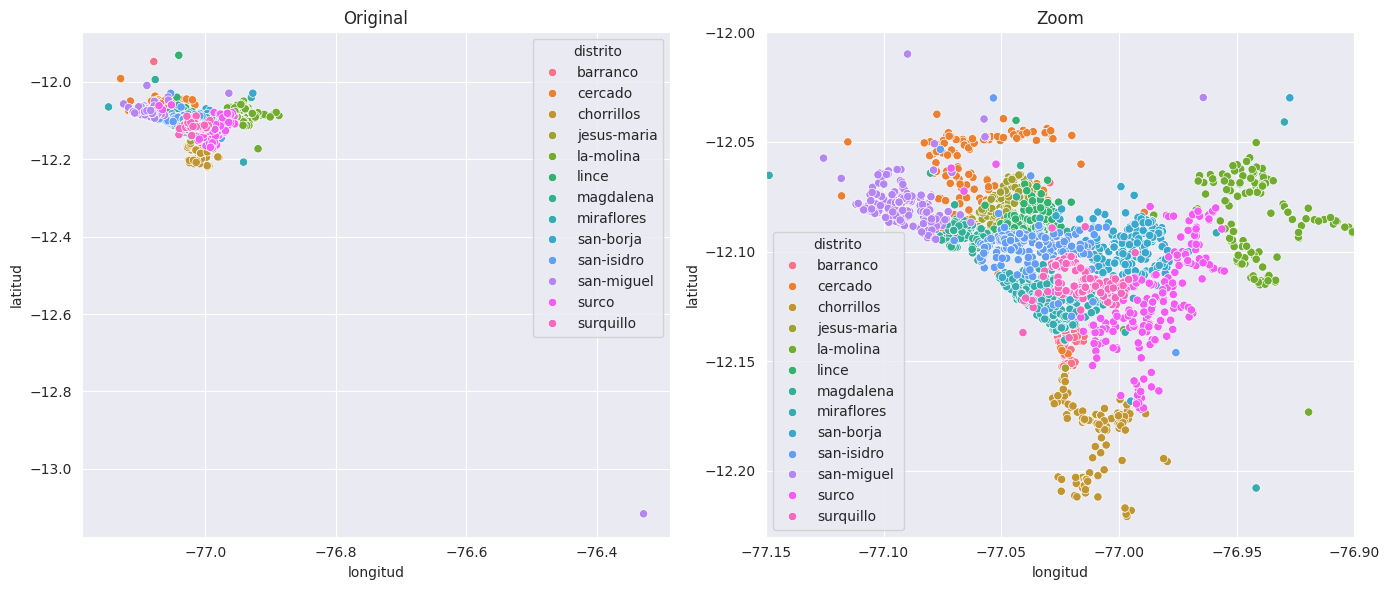

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x='longitud', y='latitud', hue='distrito', data=data)
axes[0].set_title("Original")

sns.scatterplot(ax=axes[1], x='longitud', y='latitud', hue='distrito', data=data)
axes[1].set_xlim((-77.15, -76.9))
axes[1].set_ylim((-12.23, -12.0))
axes[1].set_title("Zoom")

plt.tight_layout()
plt.show()

Se puede ver lo siguiente, ciertos departamentos cuyas coordenadas se encuentran muy alejadas de los demas departamentos **(5)** y ciertos departamentos que se salen del distrito al cual corresponden. **(6)**

In [68]:
data_copia = data.copy()
data_copia['precioxm2'] = data['precio']/data['area']
corr_matrix = data_copia.select_dtypes(include=('float')).corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Como podemos ver el precio correlaciona bastante bien con el area, como era de esperarse. Veamos ahora esta relacion mas a detalle mediante un grafico de dispersion entre los diferentes distritos.

In [69]:
distritos = data['distrito'].unique().tolist()
proporciones = []
fig,ax = plt.subplots(5,3,figsize=(20, 30))
for i,distrito in enumerate(distritos):
    f , c = i//3, i%3
    data_distrito = data.query(f"distrito=='{distrito}'") # seleccionamos el distrito
    sns.scatterplot(data=data_distrito, x='area', y='precio', ax=ax[f,c],color="blue") # preciosxm2 normales
    corr = data_distrito[['area','precio']].corr()
    ax[f,c].set_title(f"{distrito}, corr = {np.round(corr.values[0][1],2)}")
fig.show()

Se puede ver que existen ciertos distritos(cercado, la molina, lince,magdalena,etc) cuya area no correlaciona tanto con el precio, ademas se puede ver un pequeño subconjunto de instancias cuya relacion precio/area es menor que el promedio, ya que poseen un precio muy bajo para el area que tienen, se puede ver ademas que estos siguen una linea recta. **(7)**

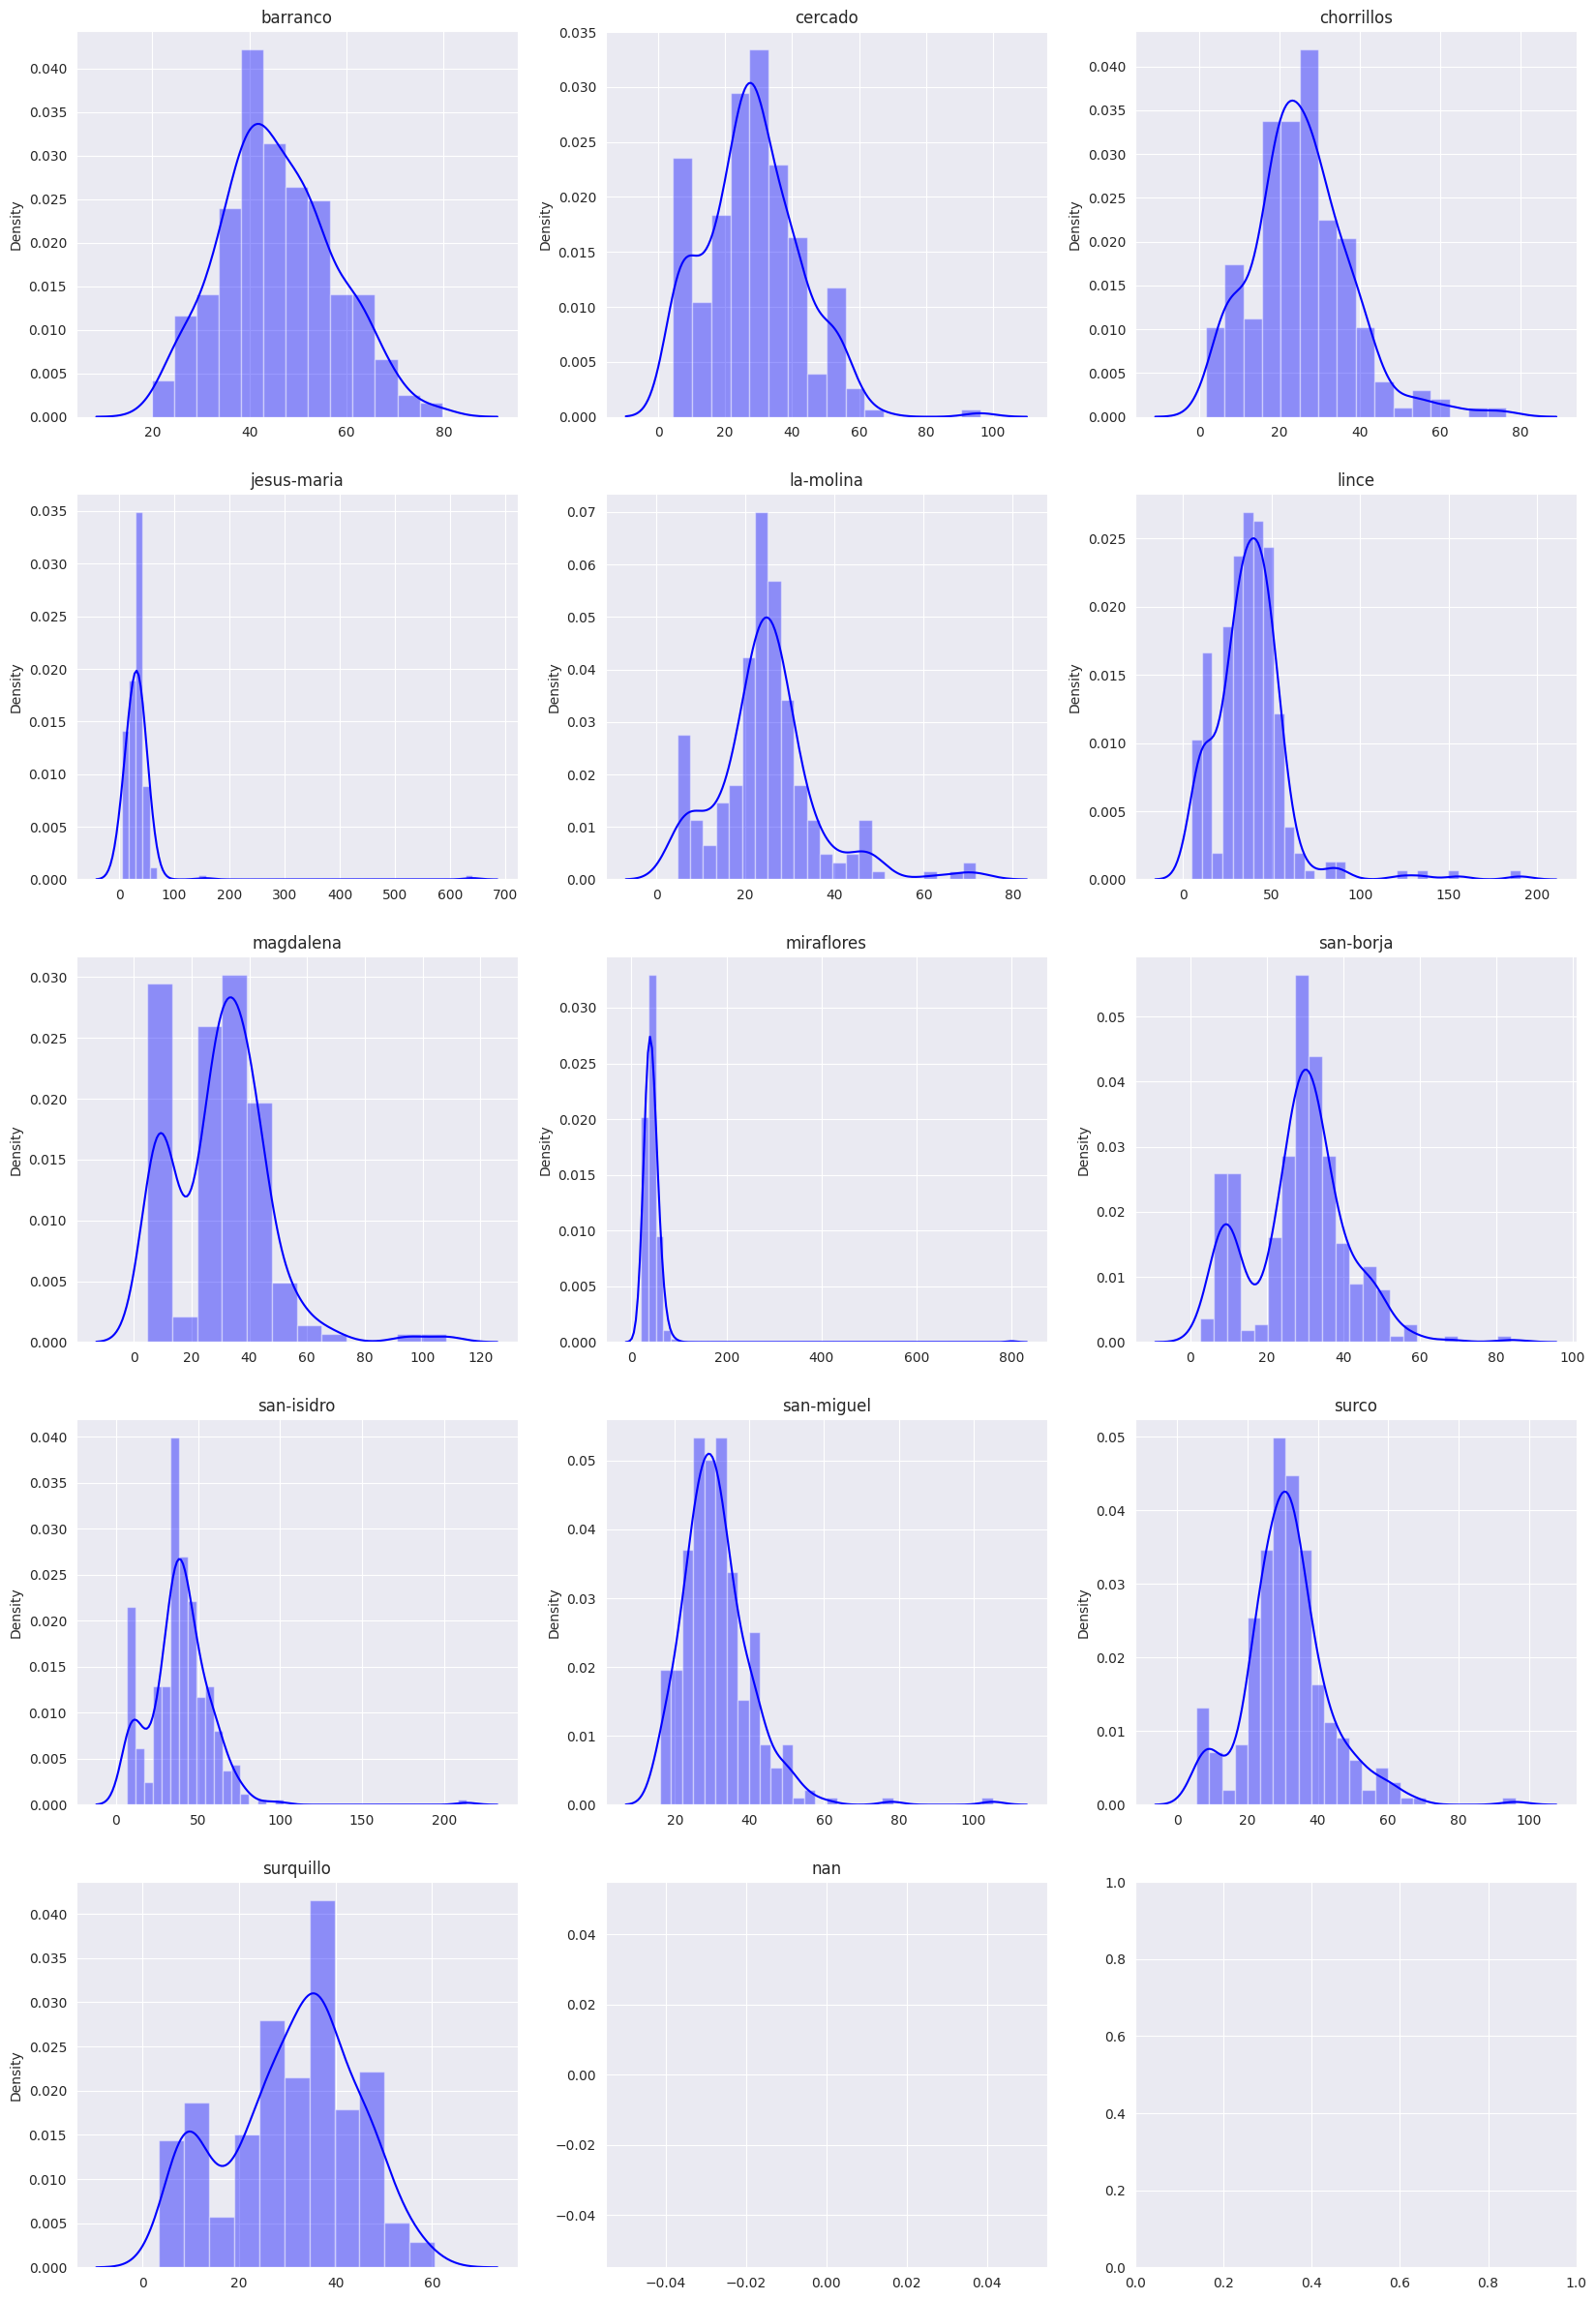

In [70]:
precioxm2 = data[['area','precio','distrito']].copy()
precioxm2['precioxm2'] = data['precio']/data['area']
fig,ax = plt.subplots(5,3,figsize=(20, 30))
for i,distrito in enumerate(distritos):
    f , c = i//3, i%3
    precioxm2_distrito = precioxm2.query(f"distrito=='{distrito}'") # seleccionamos el distrito
    sns.distplot(x=precioxm2_distrito['precioxm2'], ax=ax[f,c],color="blue") # preciosxm2 normales 
    ax[f,c].set_title(f"{distrito}")
fig.show()

Como podemos ver mas detalle la relacion precio/area, como se puede ver en algunos distritos como cercado, la molina, lince,magdalena,etc. Existe una distribucion bimodal lo cual podria estar indicando que existe un precioxm2 que proviene de 2 distribuciones normales.

### TO DO

**(1) y (2)**: La duplicacion de departamentos se da bastante ya que estos provienen de publicaciones extraidas de varias paginas, por lo que esta sujeta a que un usuario publique el mismo  departamento varias veces, el usuario publique el mismo departamento en varias paginas web, el usuario publique el mismo departamento con ligeras variaciones en el area o en el precio, etc, por lo que para abordar esto vamos a :

1. Para duplicados en la descripcion vamos a eliminar el primero, sin importar el distrito correcto, ya que sera corregido posteriormente.
2. Para duplicados que constan pequeñas variaciones en los datos vamos a usar KNN con un eps muy pequeño para poder filtrar los datos que son practicamente el mismo.


 **(3)** : Dado que el año tiene 

In [4]:
from utils.manejador_bucket import subir_archivo_a_space
#data.to_csv("../csv/datawramling1.csv")
#subir_archivo_a_space("../csv/datawramling1.csv","precios-depas-lima/csv/datawramling1.csv")

In [63]:
df = pd.read_csv("../csv/datawramling1.csv")
data = df.copy()

In [64]:
data

Unnamed: 0  fecha_publicacion    latitud  antiguedad  dormitorios  \
0              0                0.0 -12.139912         5.0          3.0   
1              2                1.0 -12.139272         0.0          2.0   
2              3                1.0 -12.139555         8.0          1.0   
3              4                1.0 -12.138541        10.0          3.0   
4              6                1.0 -12.138338         5.0          2.0   
...          ...                ...        ...         ...          ...   
3730        5470                3.0 -12.139272         0.0          2.0   
3731        5522                0.0 -12.115735        10.0          1.0   
3732        5530                5.0 -12.089232         4.0          1.0   
3733        1740                NaN -12.046689         NaN          NaN   
3734        5135                NaN -12.046689         NaN          3.0   

       longitud  banos                                        descripcion  \
0    -77.018606    2.0  Se Alquila Lindo Departamento en Barranco\n¡De...   
1    -77.021154    2.0  Se Alquila Departamento Duplex en Corazón de B...   
2    -77.023879    1.0  Se Alquila Lindo Departamento en Barranco\nSE ...   
3    -77.017627    2.0  Departamento de 3 Habitaciones Sin Amoblar en ...   
4    -77.025239    1.0  Se Alquila Lindo Departamento en La Av El Sol ...   
...         ...    ...                                                ...   
3730 -77.021154    2.0  Se Alquila Departamento Duplex en Corazón de B...   
3731 -77.019023    1.0  Surquillo Minidepa Funcional 700 Soles Incluye...   
3732 -77.028411    1.0  Departamento Exclusivo en Alquiler en Lince 1 ...   
3733 -77.043089    NaN                                                NaN   
3734 -77.043089    2.0                                                NaN   

      area  precio   distrito  \
0     77.0  2960.0   barranco   
1     96.0  2250.0   barranco   
2     40.0  2000.0   barranco   
3     80.0  2974.0   barranco   
4     70.0  2800.0   barranco   
...    ...     ...        ...   
3730  96.0  2250.0  surquillo   
3731  35.0   700.0  surquillo   
3732  49.0  2300.0  surquillo   
3733   NaN     NaN        NaN   
3734   NaN     NaN        NaN   

                                              direccion         precision  \
0          Ca. Enrique Barrón 280, Barranco 15063, Peru           ROOFTOP   
1                      Jr. Tumbes 306, Lima 15063, Peru           ROOFTOP   
2      Av. el Sol Oeste 203 - 504, Barranco 15063, Peru           ROOFTOP   
3     Av. República de Panamá 330, Barranco 15049, Peru           ROOFTOP   
4     Edificio El Sol 450, Av. el Sol Oeste 448, Bar...           ROOFTOP   
...                                                 ...               ...   
3730                   Jr. Tumbes 306, Lima 15063, Peru           ROOFTOP   
3731                    VXMJ+PC2, Surquillo 15047, Peru  GEOMETRIC_CENTER   
3732                  Orquideas 2631, Lince 15046, Peru           ROOFTOP   
3733                                   nan, Lima, Perú.       APPROXIMATE   
3734                                   nan, Lima, Perú.       APPROXIMATE   

                 type  
0      street_address  
1      street_address  
2       establishment  
3       establishment  
4          subpremise  
...               ...  
3730   street_address  
3731    establishment  
3732   street_address  
3733  colloquial_area  
3734  colloquial_area  

[3735 rows x 14 columns]

In [65]:
data.isnull().mean().sort_values(ascending=False)

antiguedad           0.308434
area                 0.042838
precio               0.016064
dormitorios          0.012048
banos                0.007497
descripcion          0.004284
fecha_publicacion    0.001339
distrito             0.000535
Unnamed: 0           0.000000
latitud              0.000000
longitud             0.000000
direccion            0.000000
precision            0.000000
type                 0.000000
dtype: float64

In [66]:
data.dropna(subset=['precio','dormitorios','banos','fecha_publicacion','distrito'],inplace=True)

In [67]:
data.describe()

Unnamed: 0  fecha_publicacion      latitud   antiguedad  dormitorios  \
count  3643.000000        3643.000000  3643.000000  2530.000000  3643.000000   
mean   2884.470491          19.592918   -12.104481     9.280040     2.188581   
std    1523.240227          31.529774     0.035627     8.542264     0.887933   
min       0.000000           0.000000   -13.115875     0.000000     0.000000   
25%    1675.500000           5.000000   -12.122254     2.000000     1.000000   
50%    2822.000000          11.000000   -12.097623     8.000000     2.000000   
75%    4233.000000          30.000000   -12.083671    14.000000     3.000000   
max    5530.000000         365.000000   -11.931811    50.000000     7.000000   

          longitud        banos         area        precio  
count  3643.000000  3643.000000  3513.000000   3643.000000  
mean    -77.026416     1.827340    93.445901   2887.062339  
std       0.038870     0.775517    62.149133   2106.740250  
min     -77.148619     1.000000     1.000000    222.000000  
25%     -77.046039     1.000000    57.000000   1800.000000  
50%     -77.028479     2.000000    76.000000   2400.000000  
75%     -77.007450     2.000000   107.000000   3300.000000  
max     -76.328472     6.000000   700.000000  19855.000000

### 1. Correccion de direcciones

1.1. Eliminacion de coordenadas muy lejanas : Usaremos DBSCAN junto a la distancia haversine y un radio de 1km para poder separar los puntos muy alejados que posiblemente no se encuentren en los distritos de nuestro estudio, esto funciona ya que DBSCAN forma grupos de manera iterativa con la condicicon que se encuentren a una distancia menor o igual a 1km, los puntos que no tengan a ningun otro punto a esa distancia (outliers) se les dara el valor de -1 ya que no pertenecen a ningun grupo.

In [68]:

X = data[['latitud','longitud']].dropna()
dbscan = DBSCAN(eps=1,metric=haversine,n_jobs=6)
X['cluster'] = dbscan.fit_predict(X)
X['cluster'].value_counts()

cluster
 0    3533
 2      79
-1      25
 1       6
Name: count, dtype: int64

Como podemos ver existen 25 departamentos muy alejados...

In [69]:
X['outlier'] = np.where(X['cluster']==-1,1,0)
plt.figure(figsize=(15,10))
sns.scatterplot(x='longitud', y='latitud', hue='outlier', data=X)
plt.show()

Como podemos ver los puntos anaranjados representan los puntos alejados de los demas.

In [70]:
indices_outlier = X[X['outlier']==1].index
data.drop(index=indices_outlier,inplace=True)

Eliminamos esos puntos ...

1.2. Corrección del distrito a partir de las coordenadas: Tambien se pudo ver que existen ciertos departamentos que no se encuentran en su distrito respectivo, esto se puede deber a que en la pagina web se recomiendan departamentos de distritos similares. Para poder corregir este error vamos a usar KNN e imputar el distrito según el distrito de sus k vecinos más cercanos.   

In [71]:
from sklearn.neighbors import KNeighborsClassifier
X = data[['latitud','longitud']]
y = data['distrito']
knn = KNeighborsClassifier(n_neighbors=10,metric=haversine,n_jobs=6)
knn.fit(X,y)
X['distrito'] = knn.predict(X)

Entrenamos y predecimos los distritos de cada depa.

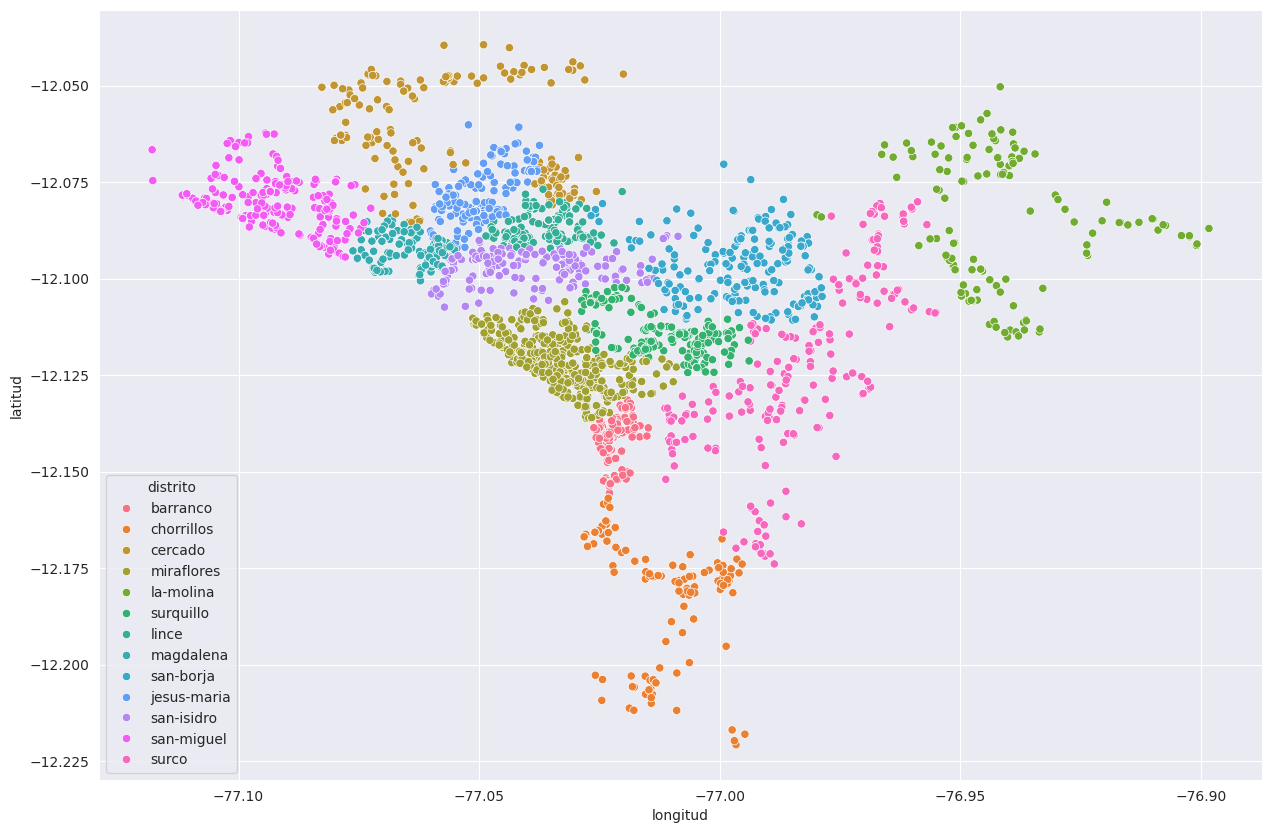

In [72]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='longitud', y='latitud', hue='distrito', data=X)
plt.show()

Como podemos ver ahora tenemos una disticcion notable de los distritos de cada departamento.

In [73]:
data['distrito'] = X['distrito']

### 2. Relación area vs precio

La relación área vs precio es bien sabida la más importante. 

In [74]:
data['distrito'].value_counts()

distrito
miraflores     493
san-miguel     321
san-borja      319
surquillo      308
san-isidro     288
surco          277
cercado        274
lince          264
jesus-maria    238
barranco       236
chorrillos     211
la-molina      206
magdalena      183
Name: count, dtype: int64

2.1. Diagrama de dispersion

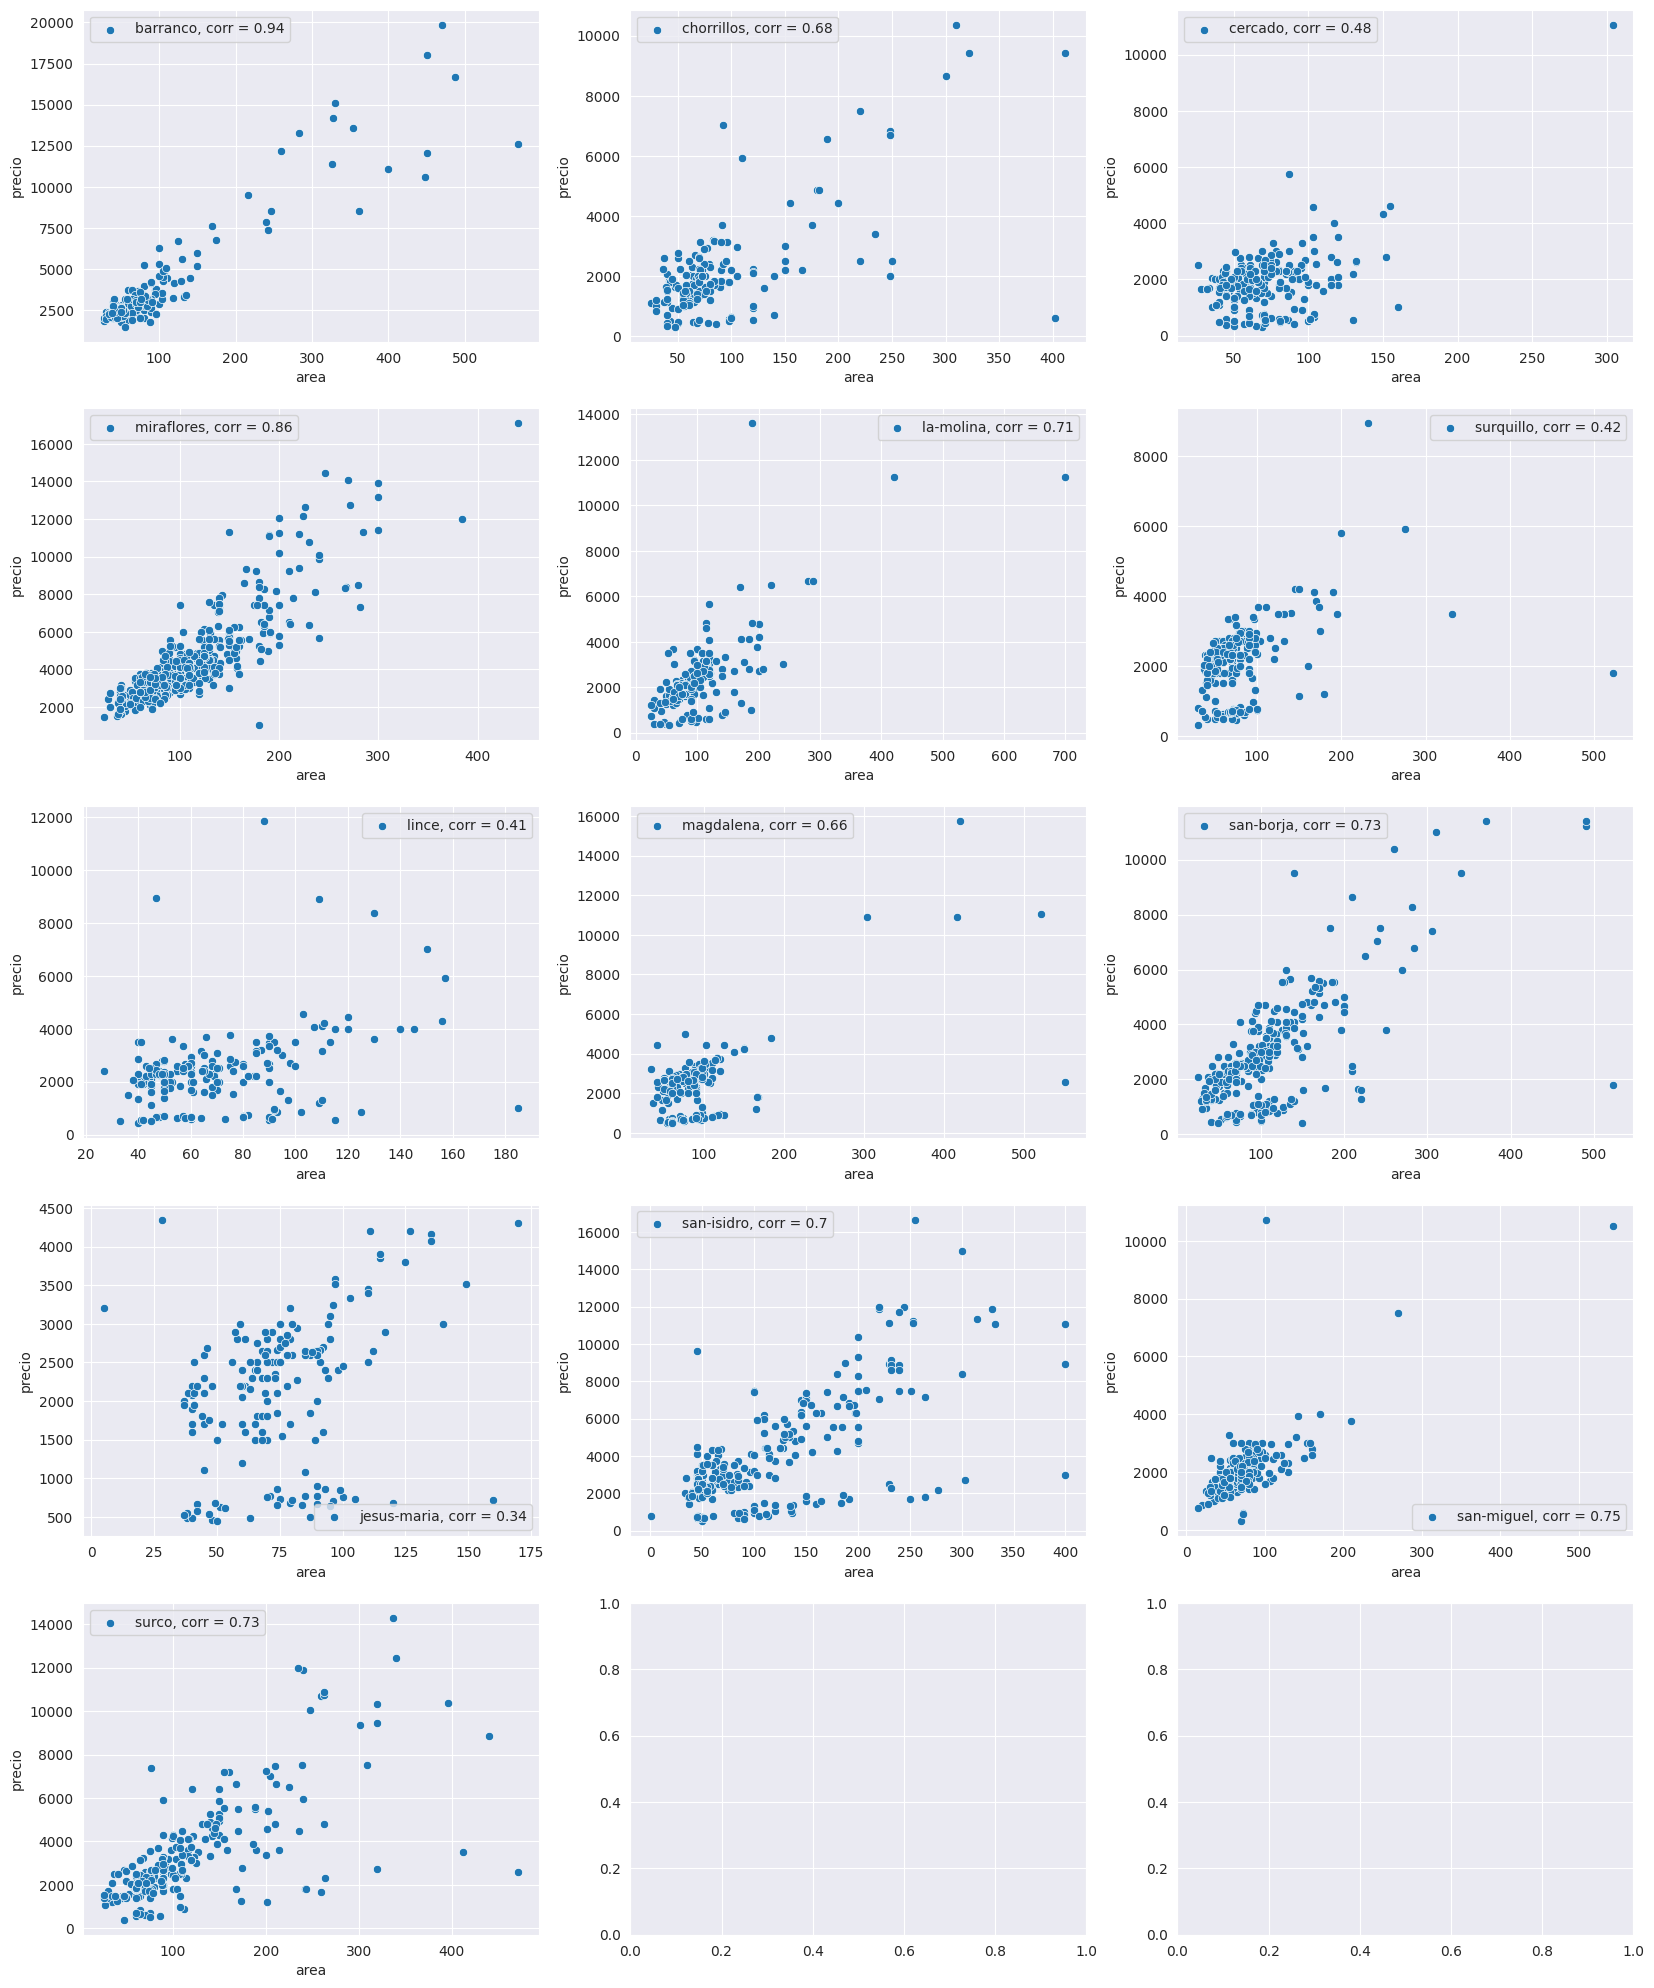

In [75]:
fig, ax = plt.subplots(5,3,figsize=(20,25))
distritos = data['distrito'].unique()
for i,distrito in enumerate(distritos):
    f,c = i//3,i%3
    data_distrito = data.query(f"distrito=='{distrito}'")
    data_distrito['precioxm2'] = data_distrito['precio']/data_distrito['area']
    corr = np.round(data_distrito[['precio','area']].corr().values[0][1],2)
    sns.scatterplot(data=data_distrito,x='area',y='precio',ax=ax[f,c],label=f"{distrito}, corr = {corr}")
fig.show()

Como mencionamos anteriormente se puede ver que existen ciertos distritos(cercado, la molina, lince,magdalena,etc) cuya area no correlacionan tanto con el precio, ademas se puede ver un pequeño subconjunto de instancias cuya relacion precio/area es menor que el promedio, ya que poseen un precio muy bajo para el area que tienen, se puede ver ademas que estos siguen una linea recta.

2.2. Diagrama de dispersion resaltando las inconsitencias

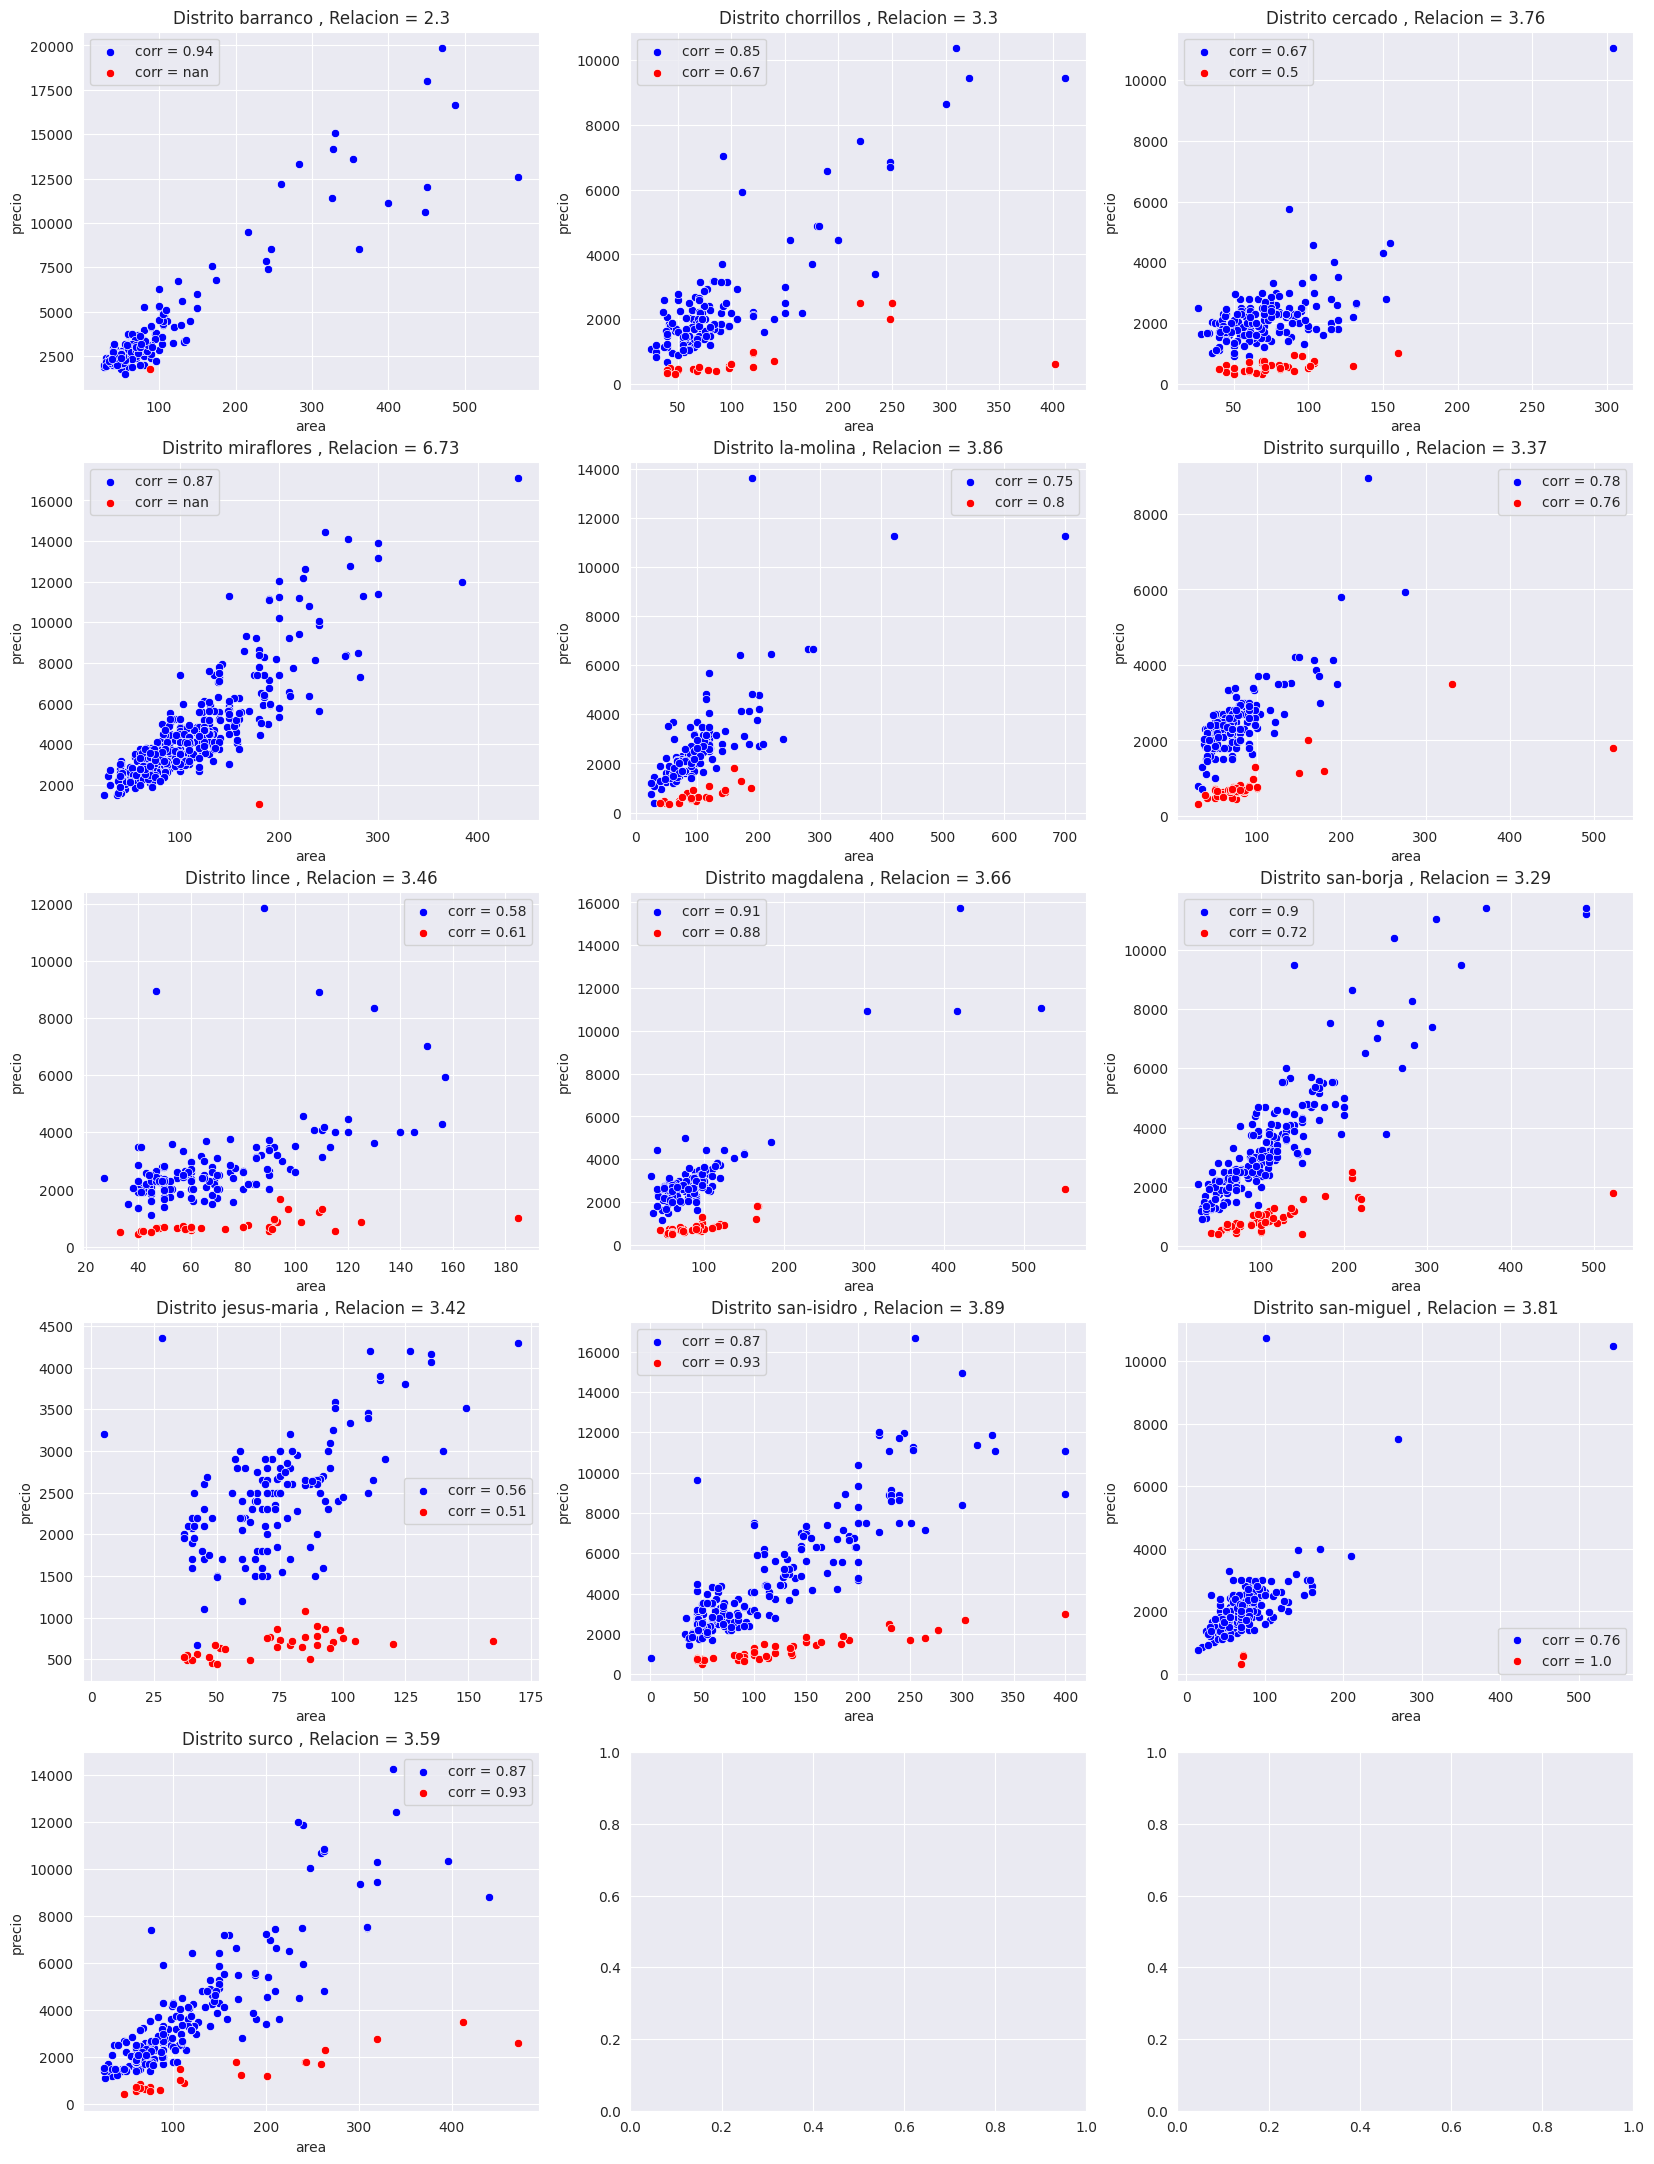

In [76]:
fig, ax = plt.subplots(5,3,figsize=(20,27))
distritos = data['distrito'].unique()
relaciones = []
indices_out = []

for i,distrito in enumerate(distritos):
    
    f,c = i//3,i%3
    data_distrito = data.query(f"distrito=='{distrito}'")
    data_distrito['precioxm2'] = data_distrito['precio']/data_distrito['area']
    
    mediana_precioxm2 = data_distrito['precioxm2'].median()
    data_distrito_no_out = data_distrito.query(f"2.1*precioxm2>=@mediana_precioxm2")
    corr_no_out = np.round(data_distrito_no_out[['precio','area']].corr().values[0][1],2)
    sns.scatterplot(data=data_distrito_no_out,x='area',y='precio',ax=ax[f,c],label=f"corr = {corr_no_out}",color='blue')

    data_distrito_out = data_distrito.query(f"2.1*precioxm2<@mediana_precioxm2")
    corr_out = np.round(data_distrito_out[['precio','area']].corr().values[0][1],2)
    sns.scatterplot(data=data_distrito_out,x='area',y='precio',ax=ax[f,c],label=f"corr = {corr_out}",color='red')
    mediana_precioxm2_out = data_distrito_out['precioxm2'].median()
    
    relacion = np.round(mediana_precioxm2/mediana_precioxm2_out if mediana_precioxm2_out else 0,2)
    relaciones.append(relacion)
    
    ax[f,c].set_title(f"Distrito {distrito} , Relacion = {relacion}")
    indices_out += data_distrito_out.index.tolist()
    
fig.show()

Podemos ver ademas de que estas inconsistencias en la relacion entre area y precio presentan tambien una correlacion con el precio y ademas la relacion entre las medianas es de 3.54 lo cual es muy cercano al valor del dolar en soles..

2.3. Veamos la descripcion de las inconsistencias

Teniendo la sospecha de que el precio pueda estar en dolares en lugar de soles (lo cual hace que su valor sea 3.7 veces menos) veamos ahora la descripcion a ver si encontramos el precio en dolares o el precio en soles multiplicado por 3.7

In [77]:
system_message = '''
 Eres un asistente experto en encontrar informacion relevante acerca de una propiedad apartir de su descripcion de venta
 Tu objetivo es analizar el texto y determinar el precio del departamento y la moneda (dolares o soles)
 
 El resultado debe devolverse exclusivamente en formato JSON con la siguiente estructura, sin ningun comentario, ni anotaciones, ni explicaciones, SOLO EL JSON\n

[{'id':<id>, 'precio_api':<valor_o_null>,'moneda_api':<soles_dolares_o_null>},...]
'''

user_message = '''
Aquí tienes una lista de propiedades en formato JSON:\n

{}\n\n

Devuélveme únicamente el JSON en el formato especificado, sin comentarios, ni anotaciones, ni explicaciones adicionales.
'''

In [78]:
input = [{'id':i,'descripcion':data.loc[i,'descripcion']} for i in indices_out]
resultado = procesamiento_batch_paralelo(
    input_data=input,
    k = 20,
    system_message=system_message,
    user_message=user_message,
    max_workers=6,
    max_retries=3
)

2025-03-05 00:47:38,837 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:40,048 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:40,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:40,763 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:40,766 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:40,789 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:49,355 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:50,626 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-05 00:47:50,913 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In [272]:
resultado_df = pd.DataFrame(resultado).set_index('id')
resultado_df_concat = pd.concat([data.loc[resultado_df.index,['area','distrito','precio']],resultado_df],axis=1)
correctos = resultado_df_concat.query("precio==precio_api and moneda_api=='soles'")
en_dolares = resultado_df_concat.query("(precio!=precio_api and moneda_api=='soles') or (precio==precio_api and moneda_api=='dolares')")
print(correctos.shape,en_dolares.shape)

(5, 5) (162, 5)


Como podemos ver solo 5 coinciden con el precio original y 162 (~50%) coinciden con que el precio en soles es diferente o el precio se encuentra en dolares.

2.4. Contrastando con la ubicacion

Por ultimo verifiquemos que esto no se trata por un tema de ubicacion, zonas mas costosas y zonas menos costosas podrian estar influyendo en el precioxm2 mucho mas barato de lo normal. Para esto vamos a usar KNN y predecir el precioxm2 que en teoria deberia tener ese departamento basado en sus 3 vecinos mas cercanos, si el valor promedio es cercano a 3.7*precio_real esto podria indicar nuevamante  que el precio se encuentra en dolares y no en soles, contrastanto con la ubicaicon del departamento.

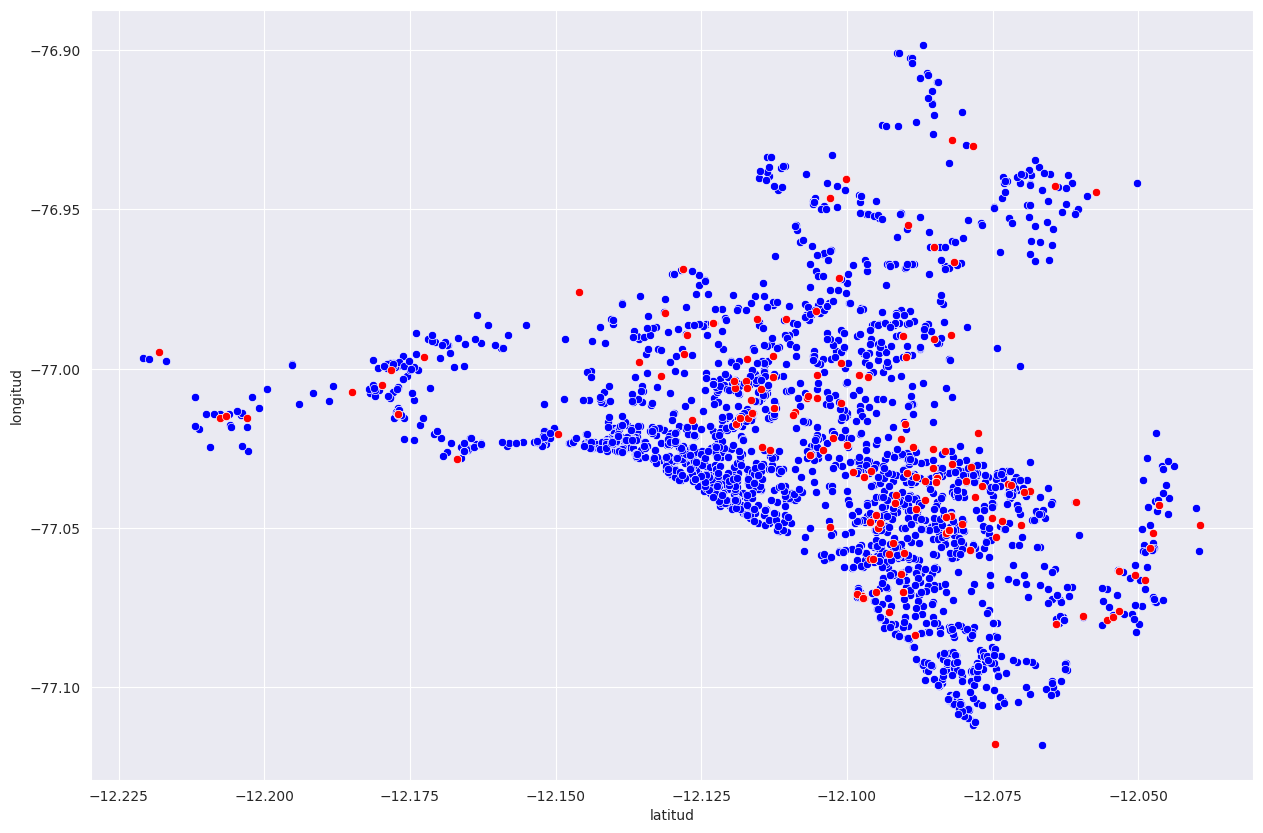

count    395.000000
mean       3.977725
std        1.517873
min        1.582532
25%        2.997834
50%        3.679266
75%        4.664429
max       15.291129
dtype: float64

In [78]:
from sklearn.neighbors import KNeighborsRegressor

plt.figure(figsize=(15,10))
sns.scatterplot(data=data,x='latitud',y='longitud',color='blue')
sns.scatterplot(data=data.loc[indices_out],x='latitud',y='longitud',color='red')
plt.show()

data_train = data.dropna(subset=['precio','area']).drop(index=indices_out)
X_train = data_train[['latitud', 'longitud']]
y_train = data_train['precio']/data_train['area']

knn_regressor = KNeighborsRegressor(n_neighbors=3,metric=haversine,n_jobs=6)
knn_regressor.fit(X_train,y_train)

precioxm2_predicho = knn_regressor.predict(data.loc[indices_out,['latitud','longitud']])
precioxm2_real = data.loc[indices_out,'precio']/data.loc[indices_out,'area']
precioxm2_diferecnia = precioxm2_predicho/precioxm2_real
precioxm2_diferecnia.describe()

Como podemos ver el precio predicho es bastante mayor que el precio normal, tomando a sus 3 vecinos mas cercanos, lo cual implicaria que el precioxm2 mas bajo de lo normal no implica una zona mas barata, ademas la relacion 3.96 en la media y 3.63 en la mediana nos estaria indicando un valor muy cercano al valor del dolar lo cual refuerza nuevamente la hipotesis de que los precios estan en dolares y no en soles.     

2.5. Hagamos los cambios

Teniendo en cuenta lo visto anteriormente, es bastante claro que los precios se encuentran en dolares lo cual implica que su valor sea 3.7 menos que el precio original, lo cual implica que el precioxm2 sea tan bajo, ahora hagamos los cambios respectivos...

In [79]:
data_copia = data.copy()
data_copia.loc[indices_out,'precio'] *= 3.7
precioxm2 = data_copia['precio']/data_copia['area']
data_copia.drop(index=precioxm2[precioxm2<10].index,inplace=True)

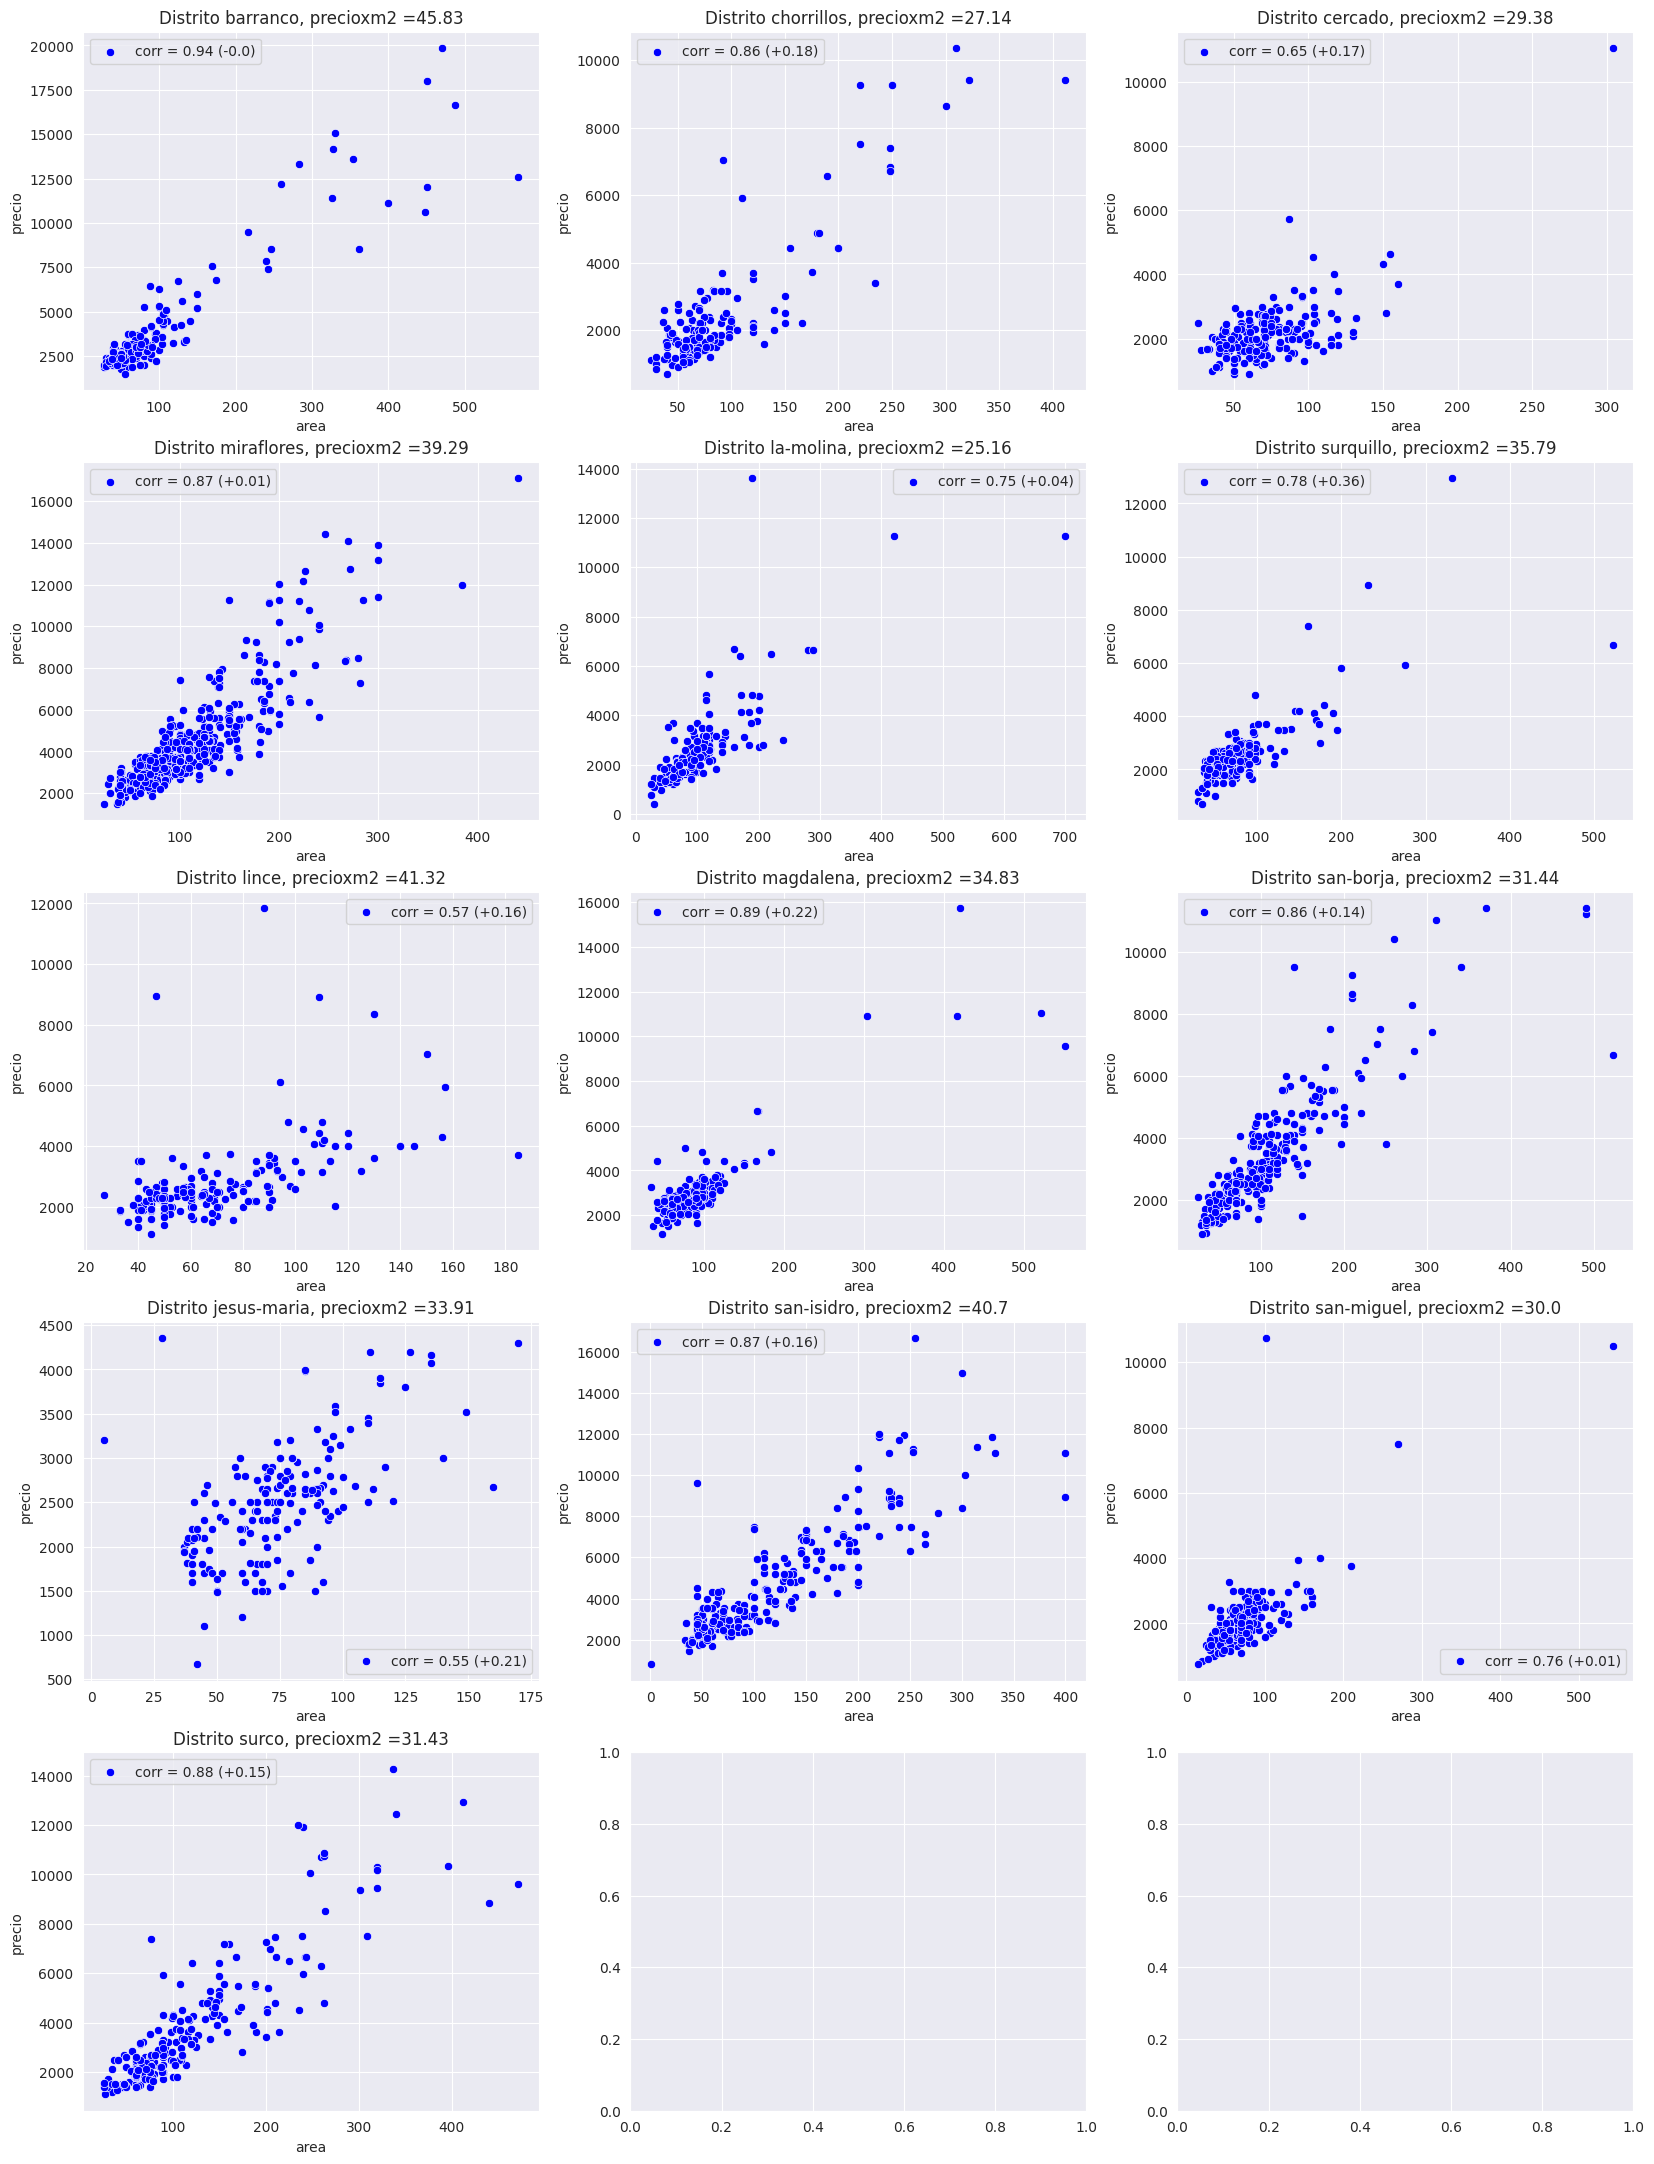

In [80]:
fig, ax = plt.subplots(5,3,figsize=(20,27))

for i,distrito in enumerate(distritos):

    f,c = i//3,i%3
    data_distrito = data_copia.query(f"distrito=='{distrito}'")

    corr = data_distrito[['precio','area']].corr().values[0][1]
    corr_real = data.query(f"distrito=='{distrito}'")[['area','precio']].corr().values[0][1]

    diff = np.round(corr-corr_real,2)
    diff = "+"+str(diff) if diff>0 else diff
    corr = np.round(corr,2)

    sns.scatterplot(data=data_distrito,x='area',y='precio',ax=ax[f,c],label=f"corr = {corr} ({diff})",color='blue')
    precioxm2 = np.round(data_distrito['precio']/data_distrito['area'],2)
    ax[f,c].set_title(f"Distrito {distrito}, precioxm2 ={np.round(precioxm2.median(),2)}")

fig.show()

Como podemos ver la  correlación ha aumentado bastante en varios distritos, lo cual apoya la idea de la importante relacion entre el area y el precio. 

In [81]:
data = data_copia.copy()

#### 3. DATA DUPLICADOS

Los duplicados como vimos anteriormente son bastante particulares para este proyecto, ya que al extraer la informacion de diferentes paginas web, podemos encontrarnos con varios casos. Como mencionamos antes, las publicaciones pueden repetirse en diferentes paginas web o puede darse el caso que se pueda scrapear varias veces la misma publicacion, esto puede introducir bastante sesgo a la hora de testear un modelo entrenado.

En particular existian 2 casos:
- departamentos en donde el area o el precio varian ligeramente y el resto de caracteristicas basiscas es igual.
- departamentos en donde la descripcion es la misma y las caracteristicas basicas tambien.

Para esto vamos a usar nuevamente DBSCAN con un muy pequeño eps=0.005 que nos ayudara a identificar esas instancias que forman un grupo que realmente son el mismo departamento en cuestion. 

In [82]:
columnas = ['latitud','longitud','dormitorios','banos','area','precio']
data_preprocessing = data.dropna(subset=columnas)

scaler = MinMaxScaler()
X_transform = scaler.fit_transform(data_preprocessing[columnas])

dbscan = DBSCAN(eps=0.005)
clusters = dbscan.fit_predict(X_transform)
clusters

array([-1, -1, -1, ..., -1, -1, -1], shape=(3487,))

Entrenamos el modelo y predecimos los grupos

In [83]:
data_preprocessing['cluster'] = clusters
data_preprocessing.query("cluster!=-1").sort_values(by='cluster',ascending=False)

Unnamed: 0  fecha_publicacion    latitud  antiguedad  dormitorios  \
3656        5394                5.0 -12.112688         2.0          3.0   
3727        5467                4.0 -12.112688         3.0          3.0   
3462        5063                5.0 -12.112688         NaN          3.0   
3454        5055                3.0 -12.112688         NaN          3.0   
3483        5084               11.0 -12.112688         NaN          3.0   
2363        3725               12.0 -12.090127         NaN          1.0   
2396        3759               20.0 -12.090127         NaN          1.0   
2352        3714               11.0 -12.090127         NaN          1.0   
2293        3654                3.0 -12.090127         NaN          1.0   
2432        3796               30.0 -12.090127         NaN          1.0   
1457        2306               28.0 -12.084808         NaN          1.0   
1351        2199                4.0 -12.084808         NaN          1.0   
1384        2232               10.0 -12.084808         NaN          1.0   
1405        2253               11.0 -12.084808         NaN          1.0   
1360        2208                5.0 -12.084808         NaN          1.0   
1367        2215                6.0 -12.084808         NaN          1.0   
1402        2250               11.0 -12.084808         NaN          1.0   
1404        2252               11.0 -12.084807         NaN          1.0   
721         1378               24.0 -12.184884         NaN          3.0   
684         1336               11.0 -12.184884         NaN          3.0   
687         1339               11.0 -12.184884         NaN          3.0   
659         1311                3.0 -12.184884         NaN          3.0   
682         1334               11.0 -12.184884         NaN          3.0   
312          757               11.0 -12.046374         NaN          3.0   
503          981               11.0 -12.046374         NaN          3.0   
314          759               11.0 -12.046374         NaN          3.0   
315          760               11.0 -12.046374         NaN          3.0   
400          846               30.0 -12.046374         NaN          3.0   
137          150                5.0 -12.126542        15.0          1.0   
1909        2875               12.0 -12.126460        20.0          1.0   
1831        2790                4.0 -12.126542        15.0          1.0   
1912        2878               12.0 -12.126272        15.0          1.0   
1845        2806                8.0 -12.125971        15.0          1.0   
1855        2816                7.0 -12.126253        20.0          1.0   

       longitud  banos                                        descripcion  \
3656 -76.995888    2.0  Surquillo. Alquilo Departamento 3 Habitaciones...   
3727 -76.995888    2.0  Alquiler de Departamento en Surquillo - La Cal...   
3462 -76.995888    2.0  Descripción\nDepartamento con excelente ubicac...   
3454 -76.995888    2.0  Descripción\nSurquillo. Alquilo lindo dpto, fr...   
3483 -76.995888    2.0  Descripción\nALQUILER de DEPARTAMENTO en Surqu...   
2363 -77.017407    1.0  Descripción\nALQUILER – FLAT DE ESTRENO - Av. ...   
2396 -77.017407    1.0  Descripción\nALQUILER – FLAT DE ESTRENO - Av. ...   
2352 -77.017407    1.0  Descripción\nALQUILER – FLAT DE ESTRENO - Av. ...   
2293 -77.017407    1.0  Descripción\nALQUILER – FLAT DE ESTRENO - Av. ...   
2432 -77.017407    1.0  Descripción\n🌟💫Alquiler de bonito departamento...   
1457 -77.035563    1.0  Descripción\nDepartamento de 1 dormitorio con ...   
1351 -77.035563    1.0  Descripción\nEN ALQUILER MINI DEPARTAMENTO EN ...   
1384 -77.035563    1.0  Descripción\nALQUILER DE DEPARTAMENTO EN SANTA...   
1405 -77.035563    1.0  Descripción\nFlat de estreno con buena ilumina...   
1360 -77.035563    1.0  Descripción\nDepartamento de 1 dormitorio a pa...   
1367 -77.035563    1.0  Descripción\nSe alquila departamento de ESTREN...   
1402 -77.035563    1.0  Descripción\n**ALQUILO DEPARTAMENTO DE ESTRENO.

Veamos cuales han formado grupos.

In [84]:
data_groupby = data_preprocessing.query("cluster!=-1"). \
    groupby('cluster').agg(dict([(col,'mean') for col in columnas]))
data_groupby

latitud   longitud  dormitorios  banos  area       precio
cluster                                                             
0       -12.126340 -77.028651          1.0    1.0  74.0  2891.166667
1       -12.046374 -77.042793          3.0    2.0  69.8  2742.440000
2       -12.184884 -77.007450          3.0    2.0  70.0  1962.480000
3       -12.084807 -77.035563          1.0    1.0  41.5  2032.112500
4       -12.090127 -77.017407          1.0    1.0  52.0  1988.020000
5       -12.112688 -76.995888          3.0    2.0  64.6  2368.400000

Tomamos la media en las caracteristicas base de todos los grupos para luego reemplazarlos por es valor.

In [85]:
data_preprocessing_rep = data_preprocessing[data_preprocessing['cluster'] != -1].copy()
clusters_rep = data_preprocessing_rep['cluster'].unique()
columnas = data_groupby.columns

for c in clusters_rep:
    cluster_mean = data_groupby.loc[c, columnas]
    data_preprocessing_rep.loc[data_preprocessing_rep['cluster'] == c, columnas] = cluster_mean.values

# Merge the updated rows back into the original DataFrame
data.update(data_preprocessing_rep)

Actualizamos...

In [86]:
data.drop_duplicates(subset=columnas,keep='first',inplace=True)
data.drop_duplicates(subset=['area','dormitorios','banos','descripcion'],keep='first',inplace=True)

Y ahora si eliminamos los duplicados, manteniendo el primero kepp='first'...

In [87]:
data.shape

(3370, 14)

#### 4. Tratamiento de nulos 

Por ultimo vamos a tratar los nulos de las variables antiguedad y area.

In [88]:
data.isnull().mean().sort_values(ascending=False)

antiguedad           0.289021
area                 0.032641
fecha_publicacion    0.000000
latitud              0.000000
dormitorios          0.000000
Unnamed: 0           0.000000
longitud             0.000000
banos                0.000000
descripcion          0.000000
precio               0.000000
distrito             0.000000
direccion            0.000000
precision            0.000000
type                 0.000000
dtype: float64

4.1. Tratamiento de nulos para area : Teniendo en cuenta que los datos faltantes son MCAR y que el % de nulos para areas es bastante pequeño (del 3.2%) por lo que haremos una imputacion de esta variable, para esto usaremos un randomforest.

- Primero enternaremos el modelo sobre los datos que mayor correlacionen con la variable.
- Segundo testearemos el modelo sobre los datos.
- Tercero, si el error del testeo es aceptable, imputaremos los valores nulos de la variable con el valor predicho por el randomforest.

In [89]:
corr = data.select_dtypes(include=['float']).corr()
corr['area'].sort_values(ascending=False)

area                 1.000000
precio               0.833732
banos                0.640313
dormitorios          0.574495
antiguedad           0.215624
longitud             0.149958
fecha_publicacion    0.069837
latitud             -0.071657
Name: area, dtype: float64

In [90]:
rfr = RandomForestRegressor(n_estimators=60,max_depth=20,min_samples_leaf=3)

not_na = data.query("area.notna()")
is_na = data.query("area.isna()")

X = not_na[['banos','dormitorios','antiguedad','longitud','latitud']]
y = not_na['area']

kfold = KFold(n_splits=10, shuffle=False, random_state=None)
mapes_rfr = []
mapes_mean = []

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    
    mapes_rfr.append(mean_absolute_percentage_error(y_test, y_pred))
    mapes_mean.append(mean_absolute_percentage_error(y_test, [np.mean(y_train)]*len(y_test)))
    
print(f"MAPE rfr promedio: {np.mean(np.sort(mapes_rfr)[1:-1])}")
print(f"MAPE imputacion media promedio: {np.mean(np.sort(mapes_mean)[1:-1])}")

MAPE rfr promedio: 0.2738724651841822
MAPE imputacion media promedio: 0.5504764240682969


Podemos ver que el error que se tiene al imputar por la media y el que se tiene al imputar por el modelo de randomforest es practicamente la mitad.

In [91]:
data_copia = data.copy()
data_copia.loc[is_na.index,'area'] = rfr.predict(is_na[['banos','dormitorios','antiguedad','longitud','latitud']])
data_copia

Unnamed: 0  fecha_publicacion    latitud  antiguedad  dormitorios  \
0              0                0.0 -12.139912         5.0          3.0   
1              2                1.0 -12.139272         0.0          2.0   
2              3                1.0 -12.139555         8.0          1.0   
3              4                1.0 -12.138541        10.0          3.0   
4              6                1.0 -12.138338         5.0          2.0   
...          ...                ...        ...         ...          ...   
3725        5465               22.0 -12.105428         5.0          1.0   
3726        5466               12.0 -12.116230         2.0          2.0   
3728        5468               17.0 -12.119018         5.0          3.0   
3729        5469                5.0 -12.112500         4.0          2.0   
3731        5522                0.0 -12.115735        10.0          1.0   

       longitud  banos                                        descripcion  \
0    -77.018606    2.0  Se Alquila Lindo Departamento en Barranco\n¡De...   
1    -77.021154    2.0  Se Alquila Departamento Duplex en Corazón de B...   
2    -77.023879    1.0  Se Alquila Lindo Departamento en Barranco\nSE ...   
3    -77.017627    2.0  Departamento de 3 Habitaciones Sin Amoblar en ...   
4    -77.025239    1.0  Se Alquila Lindo Departamento en La Av El Sol ...   
...         ...    ...                                                ...   
3725 -77.022412    1.0  Alquiler Departamento Oferta\nDepartamento en ...   
3726 -77.014257    1.0  Se Alquila Departamento en Barrio Medico\nCRIS...   
3728 -76.999006    2.0  Departamento de 3 Dorm.\nLindo departamento, b...   
3729 -77.001545    1.0  ¡Hermoso Flat Cerca Al Real Plaza de Angamos c...   
3731 -77.019023    1.0  Surquillo Minidepa Funcional 700 Soles Incluye...   

            area  precio   distrito  \
0      77.000000  2960.0   barranco   
1      96.000000  2250.0   barranco   
2      40.000000  2000.0   barranco   
3      80.000000  2974.0   barranco   
4      70.000000  2800.0   barranco   
...          ...     ...        ...   
3725   43.000000  2000.0  surquillo   
3726   44.000000  2400.0  surquillo   
3728  100.686335  2500.0  surquillo   
3729   70.000000  2300.0  surquillo   
3731   35.000000   700.0  surquillo   

                                              direccion         precision  \
0          Ca. Enrique Barrón 280, Barranco 15063, Peru           ROOFTOP   
1                      Jr. Tumbes 306, Lima 15063, Peru           ROOFTOP   
2      Av. el Sol Oeste 203 - 504, Barranco 15063, Peru           ROOFTOP   
3     Av. República de Panamá 330, Barranco 15049, Peru           ROOFTOP   
4     Edificio El Sol 450, Av. el Sol Oeste 448, Bar...           ROOFTOP   
...                                                 ...               ...   
3725  Torre A, C. Los Negocios 165, Surquillo 15047,...           ROOFTOP   
3726      C. Víctor Alzamora 481, Surquillo 15048, Peru           ROOFTOP   
3728      Pje. Indira Gandhi 130, Surquillo 15038, Peru           ROOFTOP   
3729                   José Neyra 160, Lima 15038, Peru           ROOFTOP   
3731                    VXMJ+PC2, Surquillo 15047, Peru  GEOMETRIC_CENTER   

                type  
0     street_address  
1     street_address  
2      establishment  
3      establishment  
4         subpremise  
...              ...  
3725   establishment  
3726  street_address  
3728  street_address  
3729  street_address  
3731   establishment  

[3370 rows x 14 columns]

Reemplazamos los valores nulos de area con la prediccion del modelo randomforest.

In [92]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=data,x='area',color='blue',fill=False)
sns.kdeplot(data=data_copia,x='area',color='red',fill=False)
plt.show()

La distribucion de los datos es practicamente la misma.

In [93]:
data = data_copia.copy()
data.drop('Unnamed: 0',inplace=True,axis=1)

4.2. Tratamiento de nulos para la antiguedad

Vamos a categorizar la variable antiguedad por las siguientes razones:

- El % de nulos de la variable antiguedad es muy grande como para ser imputado por un modelo, ya que podriamos estar introduciendo mucho sesgo en nuestros datos, mas aun considerando que no hay muchas variables que tengan alguna relacion con antiguedad como en el caso del area, por lo que al categorizar los datos podemos dar una categoría explicita de "desconocido" a las variables con valores nulos en antiguedad.
- Además, la correlación que tiene con el precio es casi nula, por lo que representarla como una variable numérica no aportaría información tan útil al modelo.

In [94]:
data.isnull().mean().sort_values(ascending=False)

antiguedad           0.289021
fecha_publicacion    0.000000
latitud              0.000000
dormitorios          0.000000
longitud             0.000000
banos                0.000000
descripcion          0.000000
area                 0.000000
precio               0.000000
distrito             0.000000
direccion            0.000000
precision            0.000000
type                 0.000000
dtype: float64

In [95]:
corr = data.select_dtypes(include=['float']).corr()
corr['antiguedad'].sort_values(ascending=False)

antiguedad           1.000000
area                 0.220757
dormitorios          0.219218
longitud             0.122452
precio               0.087100
banos                0.078612
latitud              0.043588
fecha_publicacion   -0.003001
Name: antiguedad, dtype: float64

Para poder realizar la categorización de la variable antigüedad, vamos a hacerlo a partir de un árbol de decisión, ya que, como sabemos, este selecciona los puntos de corte de manera óptima para maximizar la separación del precio.

In [96]:
# Ajustar un árbol de decisión
tree = DecisionTreeRegressor(max_depth=2)  # Ajusta la profundidad según sea necesario
tree.fit(data[['antiguedad']], data['precio'])

# Obtener los puntos de corte
thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold > 0])  # Filtrar valores negativos o inválidos

# Asegurarnos de que el número de labels coincida con el número de bins - 1
bins = [-1] + list(thresholds) + [data['antiguedad'].max() + 1]
labels = [f'Grupo {i+1}' for i in range(len(bins) - 1)]  # Generar etiquetas dinámicas

# Aplicar la categorización
data['antiguedad_categoria'] = pd.cut(data['antiguedad'], bins=bins, labels=labels)

print("Puntos de corte utilizados:", bins)


Puntos de corte utilizados: [-1, np.float64(1.25), np.float64(5.5), np.float64(18.5), np.float64(51.0)]


In [97]:

data['antiguedad_categoria'] = np.where(data['antiguedad_categoria'].isna(),"desconocido",data['antiguedad_categoria'])
data.drop('antiguedad',inplace=True,axis=1)
data.isnull().mean()

fecha_publicacion       0.0
latitud                 0.0
dormitorios             0.0
longitud                0.0
banos                   0.0
descripcion             0.0
area                    0.0
precio                  0.0
distrito                0.0
direccion               0.0
precision               0.0
type                    0.0
antiguedad_categoria    0.0
dtype: float64

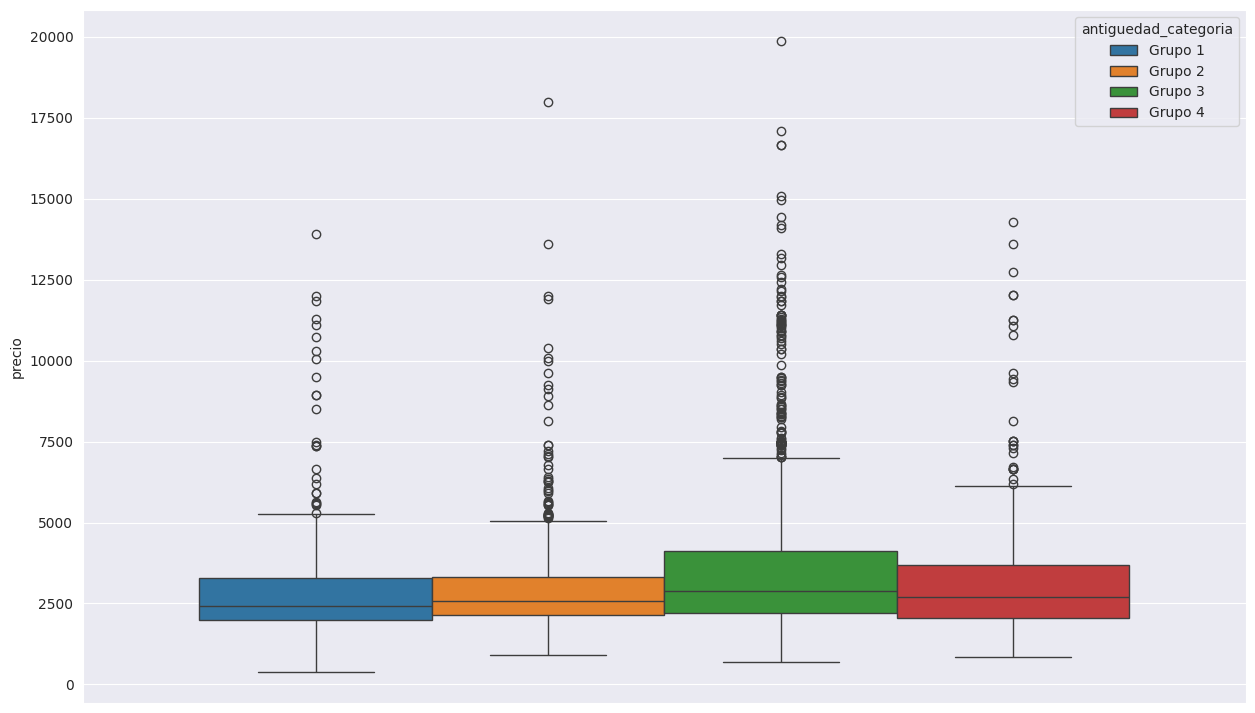

                       count         mean          std    min     25%  \
antiguedad_categoria                                                    
Grupo 1                450.0  2865.103333  1702.178759  400.0  2000.0   
Grupo 2                537.0  3043.295345  1728.278966  900.0  2146.0   
Grupo 3               1096.0  3696.043491  2511.718075  700.0  2200.0   
Grupo 4                313.0  3329.267732  2172.301475  850.0  2050.0   
desconocido            974.0  2766.388760  1711.746557  242.0  1800.0   

                              50%      75%      max  
antiguedad_categoria                                 
Grupo 1               2429.000000  3300.00  13912.0  
Grupo 2               2590.000000  3330.00  18000.0  
Grupo 3               2892.083333  4125.00  19855.0  
Grupo 4               2700.000000  3700.00  14288.0  
desconocido           2364.300000  2980.65  15725.0  


                       count       mean        std        min        25%  \
antiguedad_categoria                                                       
Grupo 1                450.0  44.556373  39.422189  13.333333  32.292140   
Grupo 2                537.0  40.521931  14.236487  12.500000  31.847134   
Grupo 3               1096.0  34.386863  10.674879  12.758621  27.397260   
Grupo 4                313.0  31.785270  10.667676  13.253012  24.666667   
desconocido            974.0  34.206832  22.556744   5.597273  25.725108   

                            50%        75%         max  
antiguedad_categoria                                    
Grupo 1               40.893570  51.671983  800.000000  
Grupo 2               39.000000  47.916667  213.777778  
Grupo 3               32.937255  39.602381  134.545455  
Grupo 4               30.163043  37.000000  108.292683  
desconocido           32.104762  40.214590  640.000000  


In [98]:
data_copia = data.copy()
data['precioxm2'] = data['precio']/data['area']

plt.figure(figsize=(15,9))
sns.boxplot(data=data,y='precio',hue='antiguedad_categoria',hue_order=labels)
plt.show()

print(data.groupby('antiguedad_categoria')['precio'].describe())

plt.figure(figsize=(15,9))
sns.boxplot(data=data,y='precioxm2',hue='antiguedad_categoria',hue_order=labels)
plt.ylim((0,100))
plt.show()

print(data.groupby('antiguedad_categoria')['precioxm2'].describe())

Se puede ver que si bien es cierto en general se ve que el precio de un departamento ha ido disminuyendo segun su antiguedad esto se debe a que el area de los departamentos antiguos era mayor, por lo que si tomamos el precioxm2 del departamento podemos notar una tendencia a la alza, lo cual es de esperarse.

### 5. Ultima revision de los datos

In [99]:
data.describe()

fecha_publicacion      latitud  dormitorios     longitud        banos  \
count        3370.000000  3370.000000  3370.000000  3370.000000  3370.000000   
mean           19.751039   -12.104933     2.193472   -77.026712     1.835312   
std            32.270875     0.030607     0.889211     0.037075     0.780361   
min             0.000000   -12.220750     0.000000   -77.117971     1.000000   
25%             5.000000   -12.122565     1.000000   -77.046549     1.000000   
50%            11.000000   -12.097852     2.000000   -77.028476     2.000000   
75%            29.000000   -12.083990     3.000000   -77.007450     2.000000   
max           365.000000   -12.039386     7.000000   -76.898329     6.000000   

              area        precio    precioxm2  
count  3370.000000   3370.000000  3370.000000  
mean     93.573660   3178.318463    36.428751  
std      61.469466   2085.538860    21.217283  
min       1.000000    242.000000     5.597273  
25%      58.000000   2000.000000    27.551020  
50%      77.000000   2590.000000    34.328358  
75%     108.000000   3515.000000    42.500000  
max     700.000000  19855.000000   800.000000

In [100]:
data_copia = data.copy()
indices = data.query("area<20 or precio<500 or dormitorios<1 or banos<1 or precioxm2<10 and precioxm2>120").index
data_copia['fecha_publicacion'] = np.where(data['fecha_publicacion']<30,0,1)
data_copia.drop(index=indices,inplace=True)
data_copia.describe()

fecha_publicacion      latitud  dormitorios     longitud        banos  \
count        3362.000000  3362.000000  3362.000000  3362.000000  3362.000000   
mean            0.249554   -12.104979     2.195717   -77.026730     1.836407   
std             0.432819     0.030616     0.888154     0.037051     0.780227   
min             0.000000   -12.220750     1.000000   -77.117971     1.000000   
25%             0.000000   -12.122679     1.000000   -77.046549     1.000000   
50%             0.000000   -12.097884     2.000000   -77.028469     2.000000   
75%             0.000000   -12.084010     3.000000   -77.007450     2.000000   
max             1.000000   -12.039386     7.000000   -76.898329     6.000000   

              area        precio    precioxm2  
count  3362.000000   3362.000000  3362.000000  
mean     93.723766   3183.425407    36.048602  
std      61.457941   2084.826646    12.969686  
min      20.000000    500.000000     6.303597  
25%      58.000000   2000.000000    27.552665  
50%      77.000000   2590.000000    34.328358  
75%     108.000000   3515.000000    42.444886  
max     700.000000  19855.000000   213.777778

In [104]:
data = data_copia.copy()

In [105]:
data.to_csv("../csv/data_wramling_final.csv")

Guardamos los datos...